# Finding optimal fixed policies for several cases to explore in the paper
---
## Setup

In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

In [2]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

In [3]:
msy_space = [Real(0.001, 0.25, name='mortality')]
log_esc_space = [Real(-6, 2, name='log_escapement')]
cr_space  = [
    Real(-5, 2, name='log_radius'),
    Real(- np.pi/4.00001, np.pi/4.00001, name='theta'),
    Real(0, 0.3, name='y2'),
]
def msy_obj_generator(config):
    @use_named_args(msy_space)
    def msy_obj(**x):
        eval_env = AsmEnv(config=config)
        agent = Msy(env=eval_env, mortality = x['mortality'])
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return msy_obj

def esc_obj_generator(config):
    @use_named_args(log_esc_space)
    def esc_obj(**x):
        eval_env = AsmEnv(config=config)
        escapement = 10 ** x['log_escapement']
        agent = ConstEsc(env=eval_env, escapement = escapement)
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return esc_obj

def cr_obj_generator(config):
    @use_named_args(cr_space)
    def cr_obj(**x):
        theta = x["theta"]
        radius = 10 ** x["log_radius"]
        x1 = np.sin(theta) * radius
        x2 = np.cos(theta) * radius
        #
        eval_env = AsmEnv(config=config)
        eval_env.reset()
        agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, 
            config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return cr_obj

## upow=0.6, non-trophy fishing

In [4]:
CONFIG1 = {
    "upow": 0.6
}

cr_obj1 = cr_obj_generator(CONFIG1)
esc_obj1 = esc_obj_generator(CONFIG1)
msy_obj1 = msy_obj_generator(CONFIG1)

In [5]:
%%time

cr_gp1 = gp_minimize(cr_obj1, cr_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
esc_gp1 = gp_minimize(esc_obj1, log_esc_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
msy_gp1 = gp_minimize(msy_obj1, msy_space, n_calls = 100, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-22 17:55:06,448	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.1426
Function value obtained: -50.2248
Current minimum: -50.2248
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 17:55:13,472	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.2930
Function value obtained: -100.0810
Current minimum: -100.0810
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 17:55:20,794	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.9121
Function value obtained: -40.3280
Current minimum: -100.0810
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 17:55:27,708	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.0030
Function value obtained: -75.6427
Current minimum: -100.0810
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 17:55:34,746	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.0246
Function value obtained: -13.8655
Current minimum: -100.0810
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 17:55:41,747	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.1452
Function value obtained: -23.8341
Current minimum: -100.0810
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 17:55:48,925	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 6.9714
Function value obtained: -133.4123
Current minimum: -133.4123
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 17:55:55,992	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 7.2094
Function value obtained: -44.7161
Current minimum: -133.4123
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 17:56:03,097	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 7.0324
Function value obtained: -10.0156
Current minimum: -133.4123
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 17:56:10,134	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.4595
Function value obtained: -0.0036
Current minimum: -133.4123
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 17:56:17,575	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 7.3179
Function value obtained: -0.0000
Current minimum: -133.4123
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 17:56:24,887	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.2691
Function value obtained: -131.0600
Current minimum: -133.4123
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 17:56:33,250	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.7377
Function value obtained: -61.4294
Current minimum: -133.4123
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 17:56:40,944	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 7.4950
Function value obtained: -131.3133
Current minimum: -133.4123
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 17:56:48,433	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.5838
Function value obtained: -135.3706
Current minimum: -135.3706
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 17:56:56,022	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.6447
Function value obtained: -137.0071
Current minimum: -137.0071
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 17:57:03,674	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.5230
Function value obtained: -138.9258
Current minimum: -138.9258
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 17:57:11,201	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.5191
Function value obtained: -135.8094
Current minimum: -138.9258
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 17:57:18,725	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 7.5404
Function value obtained: -132.4386
Current minimum: -138.9258
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 17:57:26,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.7329
Function value obtained: -136.2971
Current minimum: -138.9258
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 17:57:34,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.6322
Function value obtained: -140.0636
Current minimum: -140.0636
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 17:57:41,662	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.5808
Function value obtained: -141.1176
Current minimum: -141.1176
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 17:57:49,269	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.6479
Function value obtained: -142.4183
Current minimum: -142.4183
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 17:57:56,915	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.8256
Function value obtained: -138.9429
Current minimum: -142.4183
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 17:58:04,712	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.8529
Function value obtained: -138.5246
Current minimum: -142.4183
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 17:58:12,597	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.8736
Function value obtained: -131.4659
Current minimum: -142.4183
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 17:58:20,473	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.7868
Function value obtained: -146.7316
Current minimum: -146.7316
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 17:58:28,233	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.9675
Function value obtained: -149.3556
Current minimum: -149.3556
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 17:58:36,231	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.7273
Function value obtained: -149.8641
Current minimum: -149.8641
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 17:58:43,959	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.9885
Function value obtained: -148.2691
Current minimum: -149.8641
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 17:58:51,942	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 7.7775
Function value obtained: -145.5978
Current minimum: -149.8641
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 17:58:59,720	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 7.7742
Function value obtained: -145.9430
Current minimum: -149.8641
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 17:59:07,550	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 7.6758
Function value obtained: -145.8356
Current minimum: -149.8641
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 17:59:15,208	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 8.0398
Function value obtained: -0.0000
Current minimum: -149.8641
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 17:59:23,245	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.8355
Function value obtained: -123.7036
Current minimum: -149.8641
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 17:59:31,113	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.9280
Function value obtained: -146.8933
Current minimum: -149.8641
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 17:59:40,058	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.6553
Function value obtained: -96.2864
Current minimum: -149.8641
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 17:59:47,710	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 7.9087
Function value obtained: -18.2684
Current minimum: -149.8641
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 17:59:55,578	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.8215
Function value obtained: -143.3425
Current minimum: -149.8641
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 18:00:03,438	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.9729
Function value obtained: -144.0208
Current minimum: -149.8641
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 18:00:11,407	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 7.9140
Function value obtained: -59.0199
Current minimum: -149.8641
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 18:00:19,314	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 7.7575
Function value obtained: -0.0000
Current minimum: -149.8641
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 18:00:27,090	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 8.1577
Function value obtained: -102.7227
Current minimum: -149.8641
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 18:00:36,256	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.9665
Function value obtained: -146.7394
Current minimum: -149.8641
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 18:00:44,188	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.9532
Function value obtained: -146.6516
Current minimum: -149.8641
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 18:00:53,184	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.2294
Function value obtained: -148.3380
Current minimum: -149.8641
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 18:01:01,407	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 8.0417
Function value obtained: -141.8872
Current minimum: -149.8641
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 18:01:09,451	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.2552
Function value obtained: -148.2297
Current minimum: -149.8641
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 18:01:17,766	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.0794
Function value obtained: -146.6327
Current minimum: -149.8641
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 18:01:25,818	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 8.4322
Function value obtained: -145.1000
Current minimum: -149.8641
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 18:01:34,245	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 7.8712
Function value obtained: -147.2085
Current minimum: -149.8641
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 18:01:42,222	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 8.4857
Function value obtained: -146.0308
Current minimum: -149.8641
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 18:01:50,642	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 8.1465
Function value obtained: -143.2042
Current minimum: -149.8641
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 18:01:58,789	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 8.3069
Function value obtained: -147.6975
Current minimum: -149.8641
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 18:02:07,078	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 8.1248
Function value obtained: -146.0510
Current minimum: -149.8641
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 18:02:15,255	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 7.8741
Function value obtained: -146.7015
Current minimum: -149.8641
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 18:02:23,104	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 7.9997
Function value obtained: -147.0754
Current minimum: -149.8641
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 18:02:31,086	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 8.1482
Function value obtained: -142.8745
Current minimum: -149.8641
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 18:02:39,233	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 8.9888
Function value obtained: -151.0266
Current minimum: -151.0266
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 18:02:48,244	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 8.0642
Function value obtained: -149.0134
Current minimum: -151.0266
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 18:02:56,321	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 8.0512
Function value obtained: -149.8404
Current minimum: -151.0266
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 18:03:04,355	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 8.2602
Function value obtained: -147.3890
Current minimum: -151.0266
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 18:03:12,642	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 8.5360
Function value obtained: -144.6945
Current minimum: -151.0266
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 18:03:21,182	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 8.2329
Function value obtained: -146.6455
Current minimum: -151.0266
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 18:03:29,392	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 9.0400
Function value obtained: -146.3620
Current minimum: -151.0266
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 18:03:38,446	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 8.0667
Function value obtained: -147.1161
Current minimum: -151.0266
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 18:03:46,598	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 8.2680
Function value obtained: -147.8922
Current minimum: -151.0266
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 18:03:54,797	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 9.0775
Function value obtained: -149.2322
Current minimum: -151.0266
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 18:04:03,866	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 9.1962
Function value obtained: -145.0572
Current minimum: -151.0266
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 18:04:13,070	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 8.1596
Function value obtained: -143.8009
Current minimum: -151.0266
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 18:04:21,253	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 9.1386
Function value obtained: -146.0845
Current minimum: -151.0266
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 18:04:30,346	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 8.3585
Function value obtained: -145.9828
Current minimum: -151.0266
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 18:04:38,749	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 9.1646
Function value obtained: -146.7597
Current minimum: -151.0266
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 18:04:47,936	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 8.2258
Function value obtained: -147.4701
Current minimum: -151.0266
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 18:04:56,146	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 8.5693
Function value obtained: -145.4419
Current minimum: -151.0266
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 18:05:04,728	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 8.5831
Function value obtained: -147.1113
Current minimum: -151.0266
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 18:05:13,313	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 8.5982
Function value obtained: -142.1284
Current minimum: -151.0266
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 18:05:21,932	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 9.2327
Function value obtained: -145.6544
Current minimum: -151.0266
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 18:05:31,150	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.3888
Function value obtained: -148.4968
Current minimum: -151.0266
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 18:05:39,547	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 9.3289
Function value obtained: -146.2288
Current minimum: -151.0266
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 18:05:48,908	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 9.2651
Function value obtained: -147.4892
Current minimum: -151.0266
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 18:05:58,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 8.7033
Function value obtained: -144.5124
Current minimum: -151.0266
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 18:06:06,856	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 8.5694
Function value obtained: -147.1889
Current minimum: -151.0266
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 18:06:15,440	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.2216
Function value obtained: -145.0250
Current minimum: -151.0266
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 18:06:24,727	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 8.7992
Function value obtained: -146.3057
Current minimum: -151.0266
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 18:06:33,451	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 9.2868
Function value obtained: -147.3213
Current minimum: -151.0266
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 18:06:42,741	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.6152
Function value obtained: -147.7221
Current minimum: -151.0266
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 18:06:51,381	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 9.4433
Function value obtained: -145.4214
Current minimum: -151.0266
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 18:07:00,830	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 9.3968
Function value obtained: -147.6219
Current minimum: -151.0266
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 18:07:10,196	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 8.8338
Function value obtained: -147.6337
Current minimum: -151.0266
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 18:07:19,058	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 8.9760
Function value obtained: -146.3274
Current minimum: -151.0266
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 18:07:28,031	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 9.3455
Function value obtained: -144.4779
Current minimum: -151.0266
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 18:07:37,416	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.4949
Function value obtained: -145.8979
Current minimum: -151.0266
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 18:07:46,880	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 9.3499
Function value obtained: -144.4805
Current minimum: -151.0266
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 18:07:56,276	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 9.6696
Function value obtained: -144.4206
Current minimum: -151.0266
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 18:08:05,902	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 9.4384
Function value obtained: -148.4113
Current minimum: -151.0266
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 18:08:15,344	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 9.3791
Function value obtained: -147.8722
Current minimum: -151.0266
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 18:08:24,732	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 9.5231
Function value obtained: -143.9188
Current minimum: -151.0266
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 18:08:34,269	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 9.7191
Function value obtained: -146.1422
Current minimum: -151.0266
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 18:08:44,000	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 9.4630
Function value obtained: -146.4104
Current minimum: -151.0266

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 18:08:53,464	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.5263
Function value obtained: -3.1148
Current minimum: -3.1148
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 18:09:02,040	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.9127
Function value obtained: -100.4878
Current minimum: -100.4878
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 18:09:09,954	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.9788
Function value obtained: -5.2865
Current minimum: -100.4878
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 18:09:17,946	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.6109
Function value obtained: -43.6996
Current minimum: -100.4878
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 18:09:26,550	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.5982
Function value obtained: -98.7542
Current minimum: -100.4878
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 18:09:35,160	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 8.8102
Function value obtained: -7.9154
Current minimum: -100.4878
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 18:09:43,994	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.8920
Function value obtained: -8.4514
Current minimum: -100.4878
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 18:09:51,869	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.0056
Function value obtained: -32.3352
Current minimum: -100.4878
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 18:09:59,867	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.5909
Function value obtained: -6.4695
Current minimum: -100.4878
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 18:10:08,470	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 8.2068
Function value obtained: -81.0671
Current minimum: -100.4878
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 18:10:16,686	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.0693
Function value obtained: -109.5436
Current minimum: -109.5436
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 18:10:25,768	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.1009
Function value obtained: -110.8605
Current minimum: -110.8605
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 18:10:34,908	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.3745
Function value obtained: -110.1220
Current minimum: -110.8605
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 18:10:44,216	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.3563
Function value obtained: -2.7774
Current minimum: -110.8605
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 18:10:53,620	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 10.1550
Function value obtained: -109.1802
Current minimum: -110.8605
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 18:11:02,813	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.2128
Function value obtained: -110.1629
Current minimum: -110.8605
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 18:11:11,965	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.9456
Function value obtained: -108.1219
Current minimum: -110.8605
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 18:11:20,930	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.9004
Function value obtained: -109.3257
Current minimum: -110.8605
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 18:11:29,817	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.0523
Function value obtained: -110.5202
Current minimum: -110.8605
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 18:11:38,888	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.0686
Function value obtained: -108.1390
Current minimum: -110.8605
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 18:11:47,961	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.2281
Function value obtained: -111.1747
Current minimum: -111.1747
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 18:11:56,224	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.1119
Function value obtained: -110.5373
Current minimum: -111.1747
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 18:12:05,328	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.0879
Function value obtained: -106.8115
Current minimum: -111.1747
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 18:12:14,407	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.5319
Function value obtained: -108.8923
Current minimum: -111.1747
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 18:12:22,925	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.3492
Function value obtained: -110.6728
Current minimum: -111.1747
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 18:12:31,303	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.8975
Function value obtained: -106.7525
Current minimum: -111.1747
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 18:12:40,175	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.1815
Function value obtained: -111.4289
Current minimum: -111.4289
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 18:12:49,393	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.5026
Function value obtained: -109.1199
Current minimum: -111.4289
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 18:12:57,902	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.1353
Function value obtained: -107.6682
Current minimum: -111.4289
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 18:13:07,029	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.9578
Function value obtained: -112.1221
Current minimum: -112.1221
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 18:13:15,990	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.1668
Function value obtained: -109.1704
Current minimum: -112.1221
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 18:13:25,192	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.4409
Function value obtained: -106.2691
Current minimum: -112.1221
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 18:13:34,634	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.1184
Function value obtained: -113.3081
Current minimum: -113.3081
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 18:13:43,751	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.2273
Function value obtained: -108.3703
Current minimum: -113.3081
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 18:13:52,955	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.1702
Function value obtained: -109.6190
Current minimum: -113.3081
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 18:14:02,106	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.2777
Function value obtained: -109.8952
Current minimum: -113.3081
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 18:14:11,452	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.2352
Function value obtained: -111.6577
Current minimum: -113.3081
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 18:14:20,673	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.1924
Function value obtained: -109.6728
Current minimum: -113.3081
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 18:14:29,878	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.1180
Function value obtained: -110.6084
Current minimum: -113.3081
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 18:14:39,025	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.3525
Function value obtained: -106.4812
Current minimum: -113.3081
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 18:14:48,378	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.1724
Function value obtained: -111.7625
Current minimum: -113.3081
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 18:14:57,599	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 9.4404
Function value obtained: -109.5424
Current minimum: -113.3081
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 18:15:06,980	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 9.2450
Function value obtained: -109.6388
Current minimum: -113.3081
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 18:15:16,266	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 9.3724
Function value obtained: -111.0515
Current minimum: -113.3081
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 18:15:25,644	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.3912
Function value obtained: -106.5638
Current minimum: -113.3081
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 18:15:35,007	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.3482
Function value obtained: -109.9455
Current minimum: -113.3081
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 18:15:44,332	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 9.3430
Function value obtained: -110.1465
Current minimum: -113.3081
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 18:15:53,762	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 9.5137
Function value obtained: -108.0023
Current minimum: -113.3081
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 18:16:03,240	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.4510
Function value obtained: -109.0760
Current minimum: -113.3081
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 18:16:13,660	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 10.3444
Function value obtained: -109.7235
Current minimum: -113.3081
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 18:16:23,019	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 9.4180
Function value obtained: -108.2542
Current minimum: -113.3081
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 18:16:32,429	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 9.7001
Function value obtained: -112.5849
Current minimum: -113.3081
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 18:16:42,145	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 9.0735
Function value obtained: -105.9648
Current minimum: -113.3081
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 18:16:51,223	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 9.3049
Function value obtained: -104.6931
Current minimum: -113.3081
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 18:17:00,538	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 9.1241
Function value obtained: -109.6909
Current minimum: -113.3081
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 18:17:10,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 10.4527
Function value obtained: -107.6980
Current minimum: -113.3081
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 18:17:20,127	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 9.3407
Function value obtained: -109.3408
Current minimum: -113.3081
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 18:17:29,472	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 9.1528
Function value obtained: -110.0202
Current minimum: -113.3081
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 18:17:38,635	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 9.2478
Function value obtained: -108.3832
Current minimum: -113.3081
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 18:17:47,905	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 9.8375
Function value obtained: -108.9196
Current minimum: -113.3081
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 18:17:57,733	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 9.4495
Function value obtained: -109.2279
Current minimum: -113.3081
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 18:18:07,170	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 9.5630
Function value obtained: -110.3166
Current minimum: -113.3081
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 18:18:17,760	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 10.3607
Function value obtained: -112.1051
Current minimum: -113.3081
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 18:18:27,112	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 9.5396
Function value obtained: -110.6268
Current minimum: -113.3081
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 18:18:36,693	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 9.3452
Function value obtained: -108.8991
Current minimum: -113.3081
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 18:18:45,982	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 9.6449
Function value obtained: -107.6218
Current minimum: -113.3081
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 18:18:55,686	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 9.5317
Function value obtained: -109.5969
Current minimum: -113.3081
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 18:19:05,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 10.0276
Function value obtained: -107.6892
Current minimum: -113.3081
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 18:19:15,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 9.6048
Function value obtained: -106.5261
Current minimum: -113.3081
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 18:19:24,860	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 9.8810
Function value obtained: -105.0934
Current minimum: -113.3081
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 18:19:34,742	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 9.5930
Function value obtained: -109.4023
Current minimum: -113.3081
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 18:19:44,353	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 9.4152
Function value obtained: -111.5302
Current minimum: -113.3081
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 18:19:54,797	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 10.8567
Function value obtained: -111.2069
Current minimum: -113.3081
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 18:20:04,581	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 9.8912
Function value obtained: -109.4680
Current minimum: -113.3081
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 18:20:15,529	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 10.8526
Function value obtained: -109.8335
Current minimum: -113.3081
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 18:20:25,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 9.7092
Function value obtained: -109.6025
Current minimum: -113.3081
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 18:20:35,068	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 9.6532
Function value obtained: -106.9613
Current minimum: -113.3081
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 18:20:44,752	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 9.9265
Function value obtained: -110.8921
Current minimum: -113.3081
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 18:20:54,637	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 9.9273
Function value obtained: -106.4988
Current minimum: -113.3081
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 18:21:05,626	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 10.5533
Function value obtained: -106.9844
Current minimum: -113.3081
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 18:21:15,137	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 9.8004
Function value obtained: -112.6856
Current minimum: -113.3081
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 18:21:24,993	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 9.8939
Function value obtained: -106.2492
Current minimum: -113.3081
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 18:21:34,909	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 10.1197
Function value obtained: -110.9822
Current minimum: -113.3081
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 18:21:45,068	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.9651
Function value obtained: -110.7704
Current minimum: -113.3081
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 18:21:54,974	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 10.1038
Function value obtained: -108.1396
Current minimum: -113.3081
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 18:22:05,063	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 9.6300
Function value obtained: -108.5247
Current minimum: -113.3081
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 18:22:14,775	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 10.3881
Function value obtained: -108.0111
Current minimum: -113.3081
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 18:22:25,103	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 10.0992
Function value obtained: -109.6469
Current minimum: -113.3081
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 18:22:35,200	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 10.2008
Function value obtained: -110.2677
Current minimum: -113.3081
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 18:22:45,367	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 9.6477
Function value obtained: -110.3927
Current minimum: -113.3081
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 18:22:55,052	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 9.9332
Function value obtained: -110.6995
Current minimum: -113.3081
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 18:23:05,017	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 10.2438
Function value obtained: -108.0380
Current minimum: -113.3081
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 18:23:15,240	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 10.1308
Function value obtained: -109.5009
Current minimum: -113.3081
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 18:23:25,355	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 10.1166
Function value obtained: -109.2512
Current minimum: -113.3081
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 18:23:35,505	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 10.0187
Function value obtained: -109.6719
Current minimum: -113.3081
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 18:23:45,544	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 10.2409
Function value obtained: -106.2462
Current minimum: -113.3081
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 18:23:56,743	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 11.2279
Function value obtained: -107.9563
Current minimum: -113.3081
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 18:24:06,960	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 10.4646
Function value obtained: -110.8636
Current minimum: -113.3081
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 18:24:17,441	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 10.4714
Function value obtained: -108.2392
Current minimum: -113.3081
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 18:24:27,933	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 10.1199
Function value obtained: -108.1512
Current minimum: -113.3081

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 18:24:38,053	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.0648
Function value obtained: -17.6242
Current minimum: -17.6242
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 18:24:48,179	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.2865
Function value obtained: -17.5461
Current minimum: -17.6242
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 18:24:57,430	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.5097
Function value obtained: -37.2531
Current minimum: -37.2531
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 18:25:06,971	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.5651
Function value obtained: -121.9332
Current minimum: -121.9332
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 18:25:16,650	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.6386
Function value obtained: -27.4291
Current minimum: -121.9332
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 18:25:26,197	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.8095
Function value obtained: -109.6144
Current minimum: -121.9332
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 18:25:36,047	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.4082
Function value obtained: -62.5131
Current minimum: -121.9332
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 18:25:45,425	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.6892
Function value obtained: -25.3334
Current minimum: -121.9332
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 18:25:55,097	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.8643
Function value obtained: -73.6274
Current minimum: -121.9332
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 18:26:04,977	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.6215
Function value obtained: -11.9736
Current minimum: -121.9332
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 18:26:14,584	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.9584
Function value obtained: -120.6884
Current minimum: -121.9332
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 18:26:24,570	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.7566
Function value obtained: -121.4256
Current minimum: -121.9332
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 18:26:34,295	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.7532
Function value obtained: -123.2711
Current minimum: -123.2711
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 18:26:44,092	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.9136
Function value obtained: -119.5122
Current minimum: -123.2711
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 18:26:53,972	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.8257
Function value obtained: -122.9657
Current minimum: -123.2711
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 18:27:03,845	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.7340
Function value obtained: -125.2013
Current minimum: -125.2013
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 18:27:13,622	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.8894
Function value obtained: -123.6988
Current minimum: -125.2013
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 18:27:23,424	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.7726
Function value obtained: -124.8692
Current minimum: -125.2013
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 18:27:33,187	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.6934
Function value obtained: -122.4800
Current minimum: -125.2013
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 18:27:42,968	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.9766
Function value obtained: -124.7319
Current minimum: -125.2013
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 18:27:52,952	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.1488
Function value obtained: -122.1076
Current minimum: -125.2013
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 18:28:03,055	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.5009
Function value obtained: -8.8643
Current minimum: -125.2013
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 18:28:13,579	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.7307
Function value obtained: -125.2242
Current minimum: -125.2242
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 18:28:23,351	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.0418
Function value obtained: -123.6909
Current minimum: -125.2242
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 18:28:33,382	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.9569
Function value obtained: -123.1854
Current minimum: -125.2242
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 18:28:43,348	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.3169
Function value obtained: -124.0511
Current minimum: -125.2242
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 18:28:53,632	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.8593
Function value obtained: -128.2024
Current minimum: -128.2024
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 18:29:03,496	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.0411
Function value obtained: -125.8631
Current minimum: -128.2024
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 18:29:13,538	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.6858
Function value obtained: -122.9178
Current minimum: -128.2024
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 18:29:23,342	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.2887
Function value obtained: -119.8288
Current minimum: -128.2024
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 18:29:33,529	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.8899
Function value obtained: -121.8036
Current minimum: -128.2024
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 18:29:43,426	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.7102
Function value obtained: -124.2616
Current minimum: -128.2024
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 18:29:53,126	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.8853
Function value obtained: -122.2972
Current minimum: -128.2024
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 18:30:03,059	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.5582
Function value obtained: -125.4430
Current minimum: -128.2024
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 18:30:12,580	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.9967
Function value obtained: -122.9375
Current minimum: -128.2024
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 18:30:22,570	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 10.1173
Function value obtained: -122.7530
Current minimum: -128.2024
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 18:30:32,659	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 10.1666
Function value obtained: -122.6971
Current minimum: -128.2024
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 18:30:42,879	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.9232
Function value obtained: -124.7774
Current minimum: -128.2024
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 18:30:52,821	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.8226
Function value obtained: -127.6329
Current minimum: -128.2024
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 18:31:03,602	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.7612
Function value obtained: -123.4035
Current minimum: -128.2024
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 18:31:13,377	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.7890
Function value obtained: -121.5322
Current minimum: -128.2024
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 18:31:23,228	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 10.0559
Function value obtained: -121.3806
Current minimum: -128.2024
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 18:31:33,229	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 10.1698
Function value obtained: -119.6925
Current minimum: -128.2024
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 18:31:43,436	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 10.5240
Function value obtained: -124.7613
Current minimum: -128.2024
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 18:31:54,003	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.9256
Function value obtained: -123.7052
Current minimum: -128.2024
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 18:32:03,916	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 10.3407
Function value obtained: -124.0130
Current minimum: -128.2024
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 18:32:14,256	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 9.9008
Function value obtained: -122.6460
Current minimum: -128.2024
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 18:32:24,150	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 10.0070
Function value obtained: -126.5892
Current minimum: -128.2024
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 18:32:34,182	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 10.4073
Function value obtained: -123.4009
Current minimum: -128.2024
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 18:32:44,569	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 10.3187
Function value obtained: -121.8074
Current minimum: -128.2024
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 18:32:54,921	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 10.1348
Function value obtained: -124.6643
Current minimum: -128.2024
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 18:33:05,067	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 10.7630
Function value obtained: -121.6280
Current minimum: -128.2024
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 18:33:15,790	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 10.4211
Function value obtained: -118.4107
Current minimum: -128.2024
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 18:33:26,243	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 10.4146
Function value obtained: -119.7914
Current minimum: -128.2024
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 18:33:36,619	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 10.0937
Function value obtained: -124.2212
Current minimum: -128.2024
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 18:33:46,777	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 10.6871
Function value obtained: -119.5058
Current minimum: -128.2024
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 18:33:57,388	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 10.1315
Function value obtained: -122.0702
Current minimum: -128.2024
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 18:34:07,583	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 10.8392
Function value obtained: -123.9594
Current minimum: -128.2024
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 18:34:18,473	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 10.4072
Function value obtained: -122.4237
Current minimum: -128.2024
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 18:34:28,876	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 9.9652
Function value obtained: -122.4054
Current minimum: -128.2024
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 18:34:38,793	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 10.2593
Function value obtained: -122.6365
Current minimum: -128.2024
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 18:34:49,065	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 10.4918
Function value obtained: -124.1046
Current minimum: -128.2024
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 18:34:59,572	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 10.4629
Function value obtained: -122.7987
Current minimum: -128.2024
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 18:35:10,059	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 10.1056
Function value obtained: -125.7414
Current minimum: -128.2024
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 18:35:20,151	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 10.0253
Function value obtained: -121.5002
Current minimum: -128.2024
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 18:35:30,192	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 10.3737
Function value obtained: -125.4692
Current minimum: -128.2024
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 18:35:40,513	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 10.2547
Function value obtained: -123.6835
Current minimum: -128.2024
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 18:35:50,806	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 9.9426
Function value obtained: -123.3200
Current minimum: -128.2024
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 18:36:00,780	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 10.1437
Function value obtained: -121.6043
Current minimum: -128.2024
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 18:36:10,949	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 9.6519
Function value obtained: -122.7514
Current minimum: -128.2024
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 18:36:20,917	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 11.1888
Function value obtained: -123.8053
Current minimum: -128.2024
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 18:36:31,791	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 10.1231
Function value obtained: -125.6889
Current minimum: -128.2024
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 18:36:41,934	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 10.8388
Function value obtained: -127.7351
Current minimum: -128.2024
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 18:36:52,737	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 10.6161
Function value obtained: -126.6123
Current minimum: -128.2024
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 18:37:03,475	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 10.9526
Function value obtained: -122.3208
Current minimum: -128.2024
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 18:37:14,356	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 10.1861
Function value obtained: -125.1156
Current minimum: -128.2024
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 18:37:25,029	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 10.7912
Function value obtained: -123.1862
Current minimum: -128.2024
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 18:37:35,349	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 10.3672
Function value obtained: -124.2510
Current minimum: -128.2024
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 18:37:45,683	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 10.5638
Function value obtained: -125.1671
Current minimum: -128.2024
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 18:37:56,314	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 10.8461
Function value obtained: -122.6942
Current minimum: -128.2024
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 18:38:07,133	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 10.7002
Function value obtained: -124.6567
Current minimum: -128.2024
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 18:38:17,878	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 10.9417
Function value obtained: -121.7817
Current minimum: -128.2024
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 18:38:28,778	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 11.1075
Function value obtained: -120.5220
Current minimum: -128.2024
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 18:38:39,884	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 11.1988
Function value obtained: -124.6843
Current minimum: -128.2024
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 18:38:51,118	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 10.8785
Function value obtained: -120.8858
Current minimum: -128.2024
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 18:39:01,905	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 10.6365
Function value obtained: -122.1166
Current minimum: -128.2024
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 18:39:12,602	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 10.5517
Function value obtained: -123.6217
Current minimum: -128.2024
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 18:39:23,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 10.5972
Function value obtained: -123.3492
Current minimum: -128.2024
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 18:39:33,794	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 10.6335
Function value obtained: -126.9866
Current minimum: -128.2024
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 18:39:44,455	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 10.4923
Function value obtained: -121.4247
Current minimum: -128.2024
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 18:39:54,864	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 10.4419
Function value obtained: -123.7017
Current minimum: -128.2024
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 18:40:05,342	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 10.5760
Function value obtained: -124.2262
Current minimum: -128.2024
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 18:40:15,925	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 10.8301
Function value obtained: -125.8693
Current minimum: -128.2024
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 18:40:26,808	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 10.9323
Function value obtained: -124.1342
Current minimum: -128.2024
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 18:40:37,671	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 10.8595
Function value obtained: -123.5373
Current minimum: -128.2024
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 18:40:48,569	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 11.3228
Function value obtained: -120.4915
Current minimum: -128.2024
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 18:40:59,894	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 11.4824
Function value obtained: -122.1312
Current minimum: -128.2024
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 18:41:11,438	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 10.7418
Function value obtained: -124.1009
Current minimum: -128.2024
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 18:41:22,147	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 11.5864
Function value obtained: -124.0157
Current minimum: -128.2024
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 18:41:33,756	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 11.3634
Function value obtained: -121.5518
Current minimum: -128.2024
CPU times: user 1h 7min 7s, sys: 1h 8min 14s, total: 2h 15min 22s
Wall time: 46min 37s


In [6]:
print(f"""
cr.: {cr_gp1.fun:.2f}, {cr_gp1.x} 
esc: {esc_gp1.fun:.2f}, {esc_gp1.x}
msy: {msy_gp1.fun:.2f}, {msy_gp1.x}
""")


cr.: -151.03, [-0.32011410817668384, 0.03317549293764699, 0.09032157726866336] 
esc: -113.31, [-0.39913963226889937]
msy: -128.20, [0.04076301400384111]



In [7]:
import ray
ray.shutdown()

## upow=1, non-trophy fishing

In [8]:
CONFIG2 = {
    "upow": 1
}

cr_obj2 = cr_obj_generator(CONFIG2)
esc_obj2 = esc_obj_generator(CONFIG2)
msy_obj2 = msy_obj_generator(CONFIG2)

In [9]:
%%time

cr_gp2 = gp_minimize(cr_obj2, cr_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
esc_gp2 = gp_minimize(esc_obj2, log_esc_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
msy_gp2 = gp_minimize(msy_obj2, log_esc_space, n_calls = 100, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-22 18:41:45,178	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.0248
Function value obtained: -5.9724
Current minimum: -5.9724
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 18:41:55,275	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.8660
Function value obtained: -15.9630
Current minimum: -15.9630
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 18:42:05,170	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.0314
Function value obtained: -47.8077
Current minimum: -47.8077
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 18:42:16,166	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.9788
Function value obtained: -14.5273
Current minimum: -47.8077
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 18:42:26,150	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.0417
Function value obtained: -24.0273
Current minimum: -47.8077
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 18:42:37,146	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.2892
Function value obtained: -30.1455
Current minimum: -47.8077
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 18:42:47,509	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.8662
Function value obtained: -48.4105
Current minimum: -48.4105
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 18:42:58,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 10.1717
Function value obtained: -6.2904
Current minimum: -48.4105
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 18:43:08,532	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 10.5277
Function value obtained: -83.9195
Current minimum: -83.9195
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 18:43:19,109	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.4224
Function value obtained: -50.3316
Current minimum: -83.9195
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 18:43:30,426	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.7138
Function value obtained: -36.0910
Current minimum: -83.9195
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 18:43:41,191	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.1741
Function value obtained: -85.0784
Current minimum: -85.0784
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 18:43:51,369	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 10.6964
Function value obtained: -87.0753
Current minimum: -87.0753
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 18:44:03,092	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.6453
Function value obtained: -88.6745
Current minimum: -88.6745
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 18:44:13,714	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 11.2225
Function value obtained: -84.4254
Current minimum: -88.6745
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 18:44:24,887	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 10.2571
Function value obtained: -85.4937
Current minimum: -88.6745
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 18:44:36,131	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.6072
Function value obtained: -83.8924
Current minimum: -88.6745
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 18:44:46,782	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.5894
Function value obtained: -83.9604
Current minimum: -88.6745
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 18:44:57,428	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 10.7857
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 18:45:08,222	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 11.6423
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 18:45:19,863	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 11.0857
Function value obtained: -82.2186
Current minimum: -88.6745
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 18:45:30,927	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.6316
Function value obtained: -84.6019
Current minimum: -88.6745
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 18:45:41,622	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 10.7340
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 18:45:52,222	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.2421
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 18:46:02,519	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.7104
Function value obtained: -84.9129
Current minimum: -88.6745
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 18:46:13,275	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.3763
Function value obtained: -26.1337
Current minimum: -88.6745
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 18:46:23,691	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.4086
Function value obtained: -84.0755
Current minimum: -88.6745
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 18:46:34,090	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.4468
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 18:46:44,546	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.9374
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 18:46:55,480	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 11.0186
Function value obtained: -81.5174
Current minimum: -88.6745
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 18:47:07,522	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 11.5568
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 18:47:18,142	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 10.7516
Function value obtained: -77.7110
Current minimum: -88.6745
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 18:47:28,809	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 10.6104
Function value obtained: -83.2199
Current minimum: -88.6745
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 18:47:39,461	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.8024
Function value obtained: -79.7576
Current minimum: -88.6745
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 18:47:50,236	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 10.5249
Function value obtained: -84.3443
Current minimum: -88.6745
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 18:48:00,756	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 10.2010
Function value obtained: -77.2008
Current minimum: -88.6745
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 18:48:11,990	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 12.1662
Function value obtained: -80.2271
Current minimum: -88.6745
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 18:48:23,175	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 11.6192
Function value obtained: -8.5063
Current minimum: -88.6745
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 18:48:34,800	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.8566
Function value obtained: -3.7862
Current minimum: -88.6745
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 18:48:45,653	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 11.4481
Function value obtained: -3.2344
Current minimum: -88.6745
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 18:48:57,103	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 11.2688
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 18:49:08,384	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 10.7288
Function value obtained: -84.4595
Current minimum: -88.6745
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 18:49:19,118	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 10.7063
Function value obtained: -78.4889
Current minimum: -88.6745
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 18:49:30,338	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 12.0449
Function value obtained: -59.8454
Current minimum: -88.6745
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 18:49:41,847	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 10.6049
Function value obtained: -73.6175
Current minimum: -88.6745
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 18:49:53,728	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 11.9459
Function value obtained: -84.3413
Current minimum: -88.6745
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 18:50:05,445	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 12.2590
Function value obtained: -84.9368
Current minimum: -88.6745
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 18:50:16,757	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 11.7428
Function value obtained: -0.0000
Current minimum: -88.6745
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 18:50:28,479	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 10.9108
Function value obtained: -81.6157
Current minimum: -88.6745
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 18:50:39,385	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 10.5106
Function value obtained: -83.9244
Current minimum: -88.6745
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 18:50:51,558	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 13.3788
Function value obtained: -89.3415
Current minimum: -89.3415
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 18:51:03,265	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 10.8804
Function value obtained: -86.8953
Current minimum: -89.3415
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 18:51:16,589	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 13.2644
Function value obtained: -85.1525
Current minimum: -89.3415
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 18:51:29,555	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 12.8981
Function value obtained: -86.7892
Current minimum: -89.3415
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 18:51:40,348	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 11.1355
Function value obtained: -82.2920
Current minimum: -89.3415
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 18:51:51,494	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 11.1931
Function value obtained: -86.9512
Current minimum: -89.3415
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 18:52:02,616	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 11.2295
Function value obtained: -83.3199
Current minimum: -89.3415
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 18:52:13,891	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 11.2705
Function value obtained: -83.8452
Current minimum: -89.3415
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 18:52:25,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 11.1241
Function value obtained: -84.1858
Current minimum: -89.3415
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 18:52:36,306	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 11.5172
Function value obtained: -90.2582
Current minimum: -90.2582
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 18:52:47,878	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 11.5751
Function value obtained: -84.5137
Current minimum: -90.2582
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 18:52:59,421	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 12.0454
Function value obtained: -87.1609
Current minimum: -90.2582
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 18:53:11,472	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 11.2004
Function value obtained: -85.9424
Current minimum: -90.2582
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 18:53:22,894	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 12.1849
Function value obtained: -86.5487
Current minimum: -90.2582
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 18:53:34,892	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 12.2276
Function value obtained: -86.7229
Current minimum: -90.2582
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 18:53:47,064	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 11.1792
Function value obtained: -85.0491
Current minimum: -90.2582
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 18:53:58,296	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 11.5159
Function value obtained: -87.3644
Current minimum: -90.2582
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 18:54:09,842	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 11.7261
Function value obtained: -85.6815
Current minimum: -90.2582
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 18:54:21,503	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 11.6967
Function value obtained: -88.1699
Current minimum: -90.2582
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 18:54:33,364	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 11.0597
Function value obtained: -86.3618
Current minimum: -90.2582
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 18:54:45,041	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 12.8961
Function value obtained: -88.4223
Current minimum: -90.2582
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 18:54:57,221	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 12.1781
Function value obtained: -83.5344
Current minimum: -90.2582
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 18:55:09,464	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 11.4290
Function value obtained: -85.1680
Current minimum: -90.2582
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 18:55:20,941	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 11.6026
Function value obtained: -84.1598
Current minimum: -90.2582
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 18:55:32,496	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 11.6667
Function value obtained: -87.6237
Current minimum: -90.2582
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 18:55:44,135	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 11.1505
Function value obtained: -88.6482
Current minimum: -90.2582
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 18:55:55,239	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 12.0393
Function value obtained: -84.7632
Current minimum: -90.2582
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 18:56:07,334	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 11.4367
Function value obtained: -86.1388
Current minimum: -90.2582
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 18:56:18,781	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 12.3000
Function value obtained: -89.3813
Current minimum: -90.2582
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 18:56:31,117	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 12.5670
Function value obtained: -88.2972
Current minimum: -90.2582
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 18:56:43,688	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 12.5073
Function value obtained: -84.9865
Current minimum: -90.2582
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 18:56:56,137	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 12.3699
Function value obtained: -86.3100
Current minimum: -90.2582
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 18:57:08,504	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 11.7616
Function value obtained: -86.2788
Current minimum: -90.2582
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 18:57:20,255	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 11.8280
Function value obtained: -88.0902
Current minimum: -90.2582
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 18:57:32,105	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 11.1601
Function value obtained: -87.5204
Current minimum: -90.2582
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 18:57:43,326	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 12.0240
Function value obtained: -88.1710
Current minimum: -90.2582
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 18:57:55,334	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 11.7394
Function value obtained: -87.2143
Current minimum: -90.2582
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 18:58:07,046	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 12.6356
Function value obtained: -84.6836
Current minimum: -90.2582
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 18:58:19,782	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 12.6862
Function value obtained: -85.0274
Current minimum: -90.2582
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 18:58:32,391	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 11.2858
Function value obtained: -85.5836
Current minimum: -90.2582
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 18:58:45,944	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 14.1340
Function value obtained: -88.2977
Current minimum: -90.2582
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 18:58:57,903	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 12.0673
Function value obtained: -82.4661
Current minimum: -90.2582
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 18:59:09,963	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 11.9388
Function value obtained: -84.0442
Current minimum: -90.2582
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 18:59:21,924	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 12.0997
Function value obtained: -86.7391
Current minimum: -90.2582
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 18:59:33,991	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 12.4722
Function value obtained: -85.9318
Current minimum: -90.2582
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 18:59:46,448	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 12.4782
Function value obtained: -85.0170
Current minimum: -90.2582
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 18:59:58,931	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 11.8382
Function value obtained: -86.4555
Current minimum: -90.2582
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 19:00:10,777	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 12.5420
Function value obtained: -83.6674
Current minimum: -90.2582
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 19:00:23,435	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 12.3492
Function value obtained: -85.2587
Current minimum: -90.2582
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 19:00:35,743	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 12.4814
Function value obtained: -85.7160
Current minimum: -90.2582

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 19:00:48,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.0917
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 19:01:00,304	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.5236
Function value obtained: -21.3872
Current minimum: -21.3872
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 19:01:10,838	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.3990
Function value obtained: -61.4340
Current minimum: -61.4340
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 19:01:23,183	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.6861
Function value obtained: -30.5749
Current minimum: -61.4340
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 19:01:35,561	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.9329
Function value obtained: -3.9297
Current minimum: -61.4340
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 19:01:46,889	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.7872
Function value obtained: -10.5661
Current minimum: -61.4340
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 19:01:58,647	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.6260
Function value obtained: -1.9804
Current minimum: -61.4340
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 19:02:11,346	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.8230
Function value obtained: -5.2969
Current minimum: -61.4340
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 19:02:22,286	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.5219
Function value obtained: -1.9594
Current minimum: -61.4340
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 19:02:34,675	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.8681
Function value obtained: -79.6325
Current minimum: -79.6325
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 19:02:46,579	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.1325
Function value obtained: -82.9123
Current minimum: -82.9123
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 19:02:57,657	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.0311
Function value obtained: -84.5376
Current minimum: -84.5376
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 19:03:08,747	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.7218
Function value obtained: -84.4892
Current minimum: -84.5376
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 19:03:20,387	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.4979
Function value obtained: -1.9761
Current minimum: -84.5376
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 19:03:31,971	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 11.0924
Function value obtained: -83.5743
Current minimum: -84.5376
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 19:03:44,020	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 12.8763
Function value obtained: -84.5529
Current minimum: -84.5529
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 19:03:55,885	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.3417
Function value obtained: -81.7204
Current minimum: -84.5529
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 19:04:07,197	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.9443
Function value obtained: -85.3490
Current minimum: -85.3490
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 19:04:18,234	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 11.9346
Function value obtained: -84.3531
Current minimum: -85.3490
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 19:04:30,141	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.0929
Function value obtained: -85.9082
Current minimum: -85.9082
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 19:04:42,457	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 12.5980
Function value obtained: -86.7586
Current minimum: -86.7586
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 19:04:54,888	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 12.2158
Function value obtained: -83.0358
Current minimum: -86.7586
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 19:05:07,119	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.7629
Function value obtained: -84.8722
Current minimum: -86.7586
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 19:05:18,868	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.3968
Function value obtained: -85.8878
Current minimum: -86.7586
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 19:05:30,356	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.9633
Function value obtained: -84.8926
Current minimum: -86.7586
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 19:05:42,181	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 11.4213
Function value obtained: -86.3130
Current minimum: -86.7586
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 19:05:53,606	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.4698
Function value obtained: -87.6020
Current minimum: -87.6020
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 19:06:05,189	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 11.1861
Function value obtained: -83.4369
Current minimum: -87.6020
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 19:06:17,374	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 13.0788
Function value obtained: -85.9242
Current minimum: -87.6020
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 19:06:30,462	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 12.8591
Function value obtained: -85.3490
Current minimum: -87.6020
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 19:06:42,283	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 12.8357
Function value obtained: -84.9675
Current minimum: -87.6020
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 19:06:55,145	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 11.7458
Function value obtained: -87.6662
Current minimum: -87.6662
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 19:07:06,847	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 12.4007
Function value obtained: -84.6370
Current minimum: -87.6662
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 19:07:19,287	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 13.1146
Function value obtained: -86.4096
Current minimum: -87.6662
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 19:07:32,388	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 11.0060
Function value obtained: -85.3912
Current minimum: -87.6662
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 19:07:44,521	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 13.9291
Function value obtained: -85.0626
Current minimum: -87.6662
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 19:07:57,219	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 10.7253
Function value obtained: -86.2307
Current minimum: -87.6662
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 19:08:11,201	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 15.4998
Function value obtained: -86.3373
Current minimum: -87.6662
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 19:08:23,513	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 12.4992
Function value obtained: -87.0573
Current minimum: -87.6662
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 19:08:36,069	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 11.6326
Function value obtained: -85.6411
Current minimum: -87.6662
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 19:08:48,911	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 13.5245
Function value obtained: -82.7747
Current minimum: -87.6662
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 19:09:01,317	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 13.1244
Function value obtained: -88.5028
Current minimum: -88.5028
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 19:09:14,326	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 11.6625
Function value obtained: -86.1438
Current minimum: -88.5028
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 19:09:26,029	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 12.1965
Function value obtained: -84.6050
Current minimum: -88.5028
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 19:09:38,313	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 13.1221
Function value obtained: -84.3418
Current minimum: -88.5028
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 19:09:51,406	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 13.0093
Function value obtained: -84.4929
Current minimum: -88.5028
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 19:10:04,357	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 11.9171
Function value obtained: -85.1945
Current minimum: -88.5028
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 19:10:16,226	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 14.3140
Function value obtained: -81.8894
Current minimum: -88.5028
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 19:10:30,569	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 12.4836
Function value obtained: -86.0075
Current minimum: -88.5028
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 19:10:43,112	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 12.4976
Function value obtained: -85.6050
Current minimum: -88.5028
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 19:10:55,651	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 12.8227
Function value obtained: -86.3416
Current minimum: -88.5028
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 19:11:08,439	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 12.3011
Function value obtained: -86.3921
Current minimum: -88.5028
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 19:11:20,770	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 11.3639
Function value obtained: -86.7170
Current minimum: -88.5028
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 19:11:32,038	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 12.2249
Function value obtained: -87.9136
Current minimum: -88.5028
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 19:11:44,400	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 13.0663
Function value obtained: -83.7074
Current minimum: -88.5028
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 19:11:57,419	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 12.1646
Function value obtained: -83.9611
Current minimum: -88.5028
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 19:12:09,545	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 13.2143
Function value obtained: -86.3481
Current minimum: -88.5028
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 19:12:23,844	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 12.5183
Function value obtained: -87.8012
Current minimum: -88.5028
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 19:12:38,741	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 16.8534
Function value obtained: -86.6255
Current minimum: -88.5028
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 19:12:52,214	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 11.5267
Function value obtained: -85.6845
Current minimum: -88.5028
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 19:13:07,135	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 15.4344
Function value obtained: -86.8237
Current minimum: -88.5028
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 19:13:19,260	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 12.8941
Function value obtained: -83.2762
Current minimum: -88.5028
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 19:13:32,063	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 12.5444
Function value obtained: -84.9381
Current minimum: -88.5028
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 19:13:44,694	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 13.4875
Function value obtained: -84.4635
Current minimum: -88.5028
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 19:13:58,249	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 13.3168
Function value obtained: -86.0736
Current minimum: -88.5028
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 19:14:11,501	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 12.2999
Function value obtained: -86.1583
Current minimum: -88.5028
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 19:14:23,715	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 14.5058
Function value obtained: -85.1833
Current minimum: -88.5028
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 19:14:38,217	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 12.6764
Function value obtained: -88.9795
Current minimum: -88.9795
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 19:14:50,942	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 13.2883
Function value obtained: -85.7122
Current minimum: -88.9795
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 19:15:04,292	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 12.7493
Function value obtained: -83.0249
Current minimum: -88.9795
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 19:15:16,964	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 12.9523
Function value obtained: -84.1864
Current minimum: -88.9795
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 19:15:31,018	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 12.9677
Function value obtained: -85.4601
Current minimum: -88.9795
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 19:15:42,980	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 12.5693
Function value obtained: -86.4198
Current minimum: -88.9795
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 19:15:55,522	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 12.2483
Function value obtained: -83.5641
Current minimum: -88.9795
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 19:16:07,763	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 12.7245
Function value obtained: -83.6426
Current minimum: -88.9795
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 19:16:20,526	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 11.1246
Function value obtained: -85.6648
Current minimum: -88.9795
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 19:16:34,656	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 14.8312
Function value obtained: -83.9867
Current minimum: -88.9795
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 19:16:48,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 13.4259
Function value obtained: -82.5118
Current minimum: -88.9795
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 19:17:02,821	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 15.2356
Function value obtained: -86.3403
Current minimum: -88.9795
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 19:17:15,118	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 13.1240
Function value obtained: -83.6473
Current minimum: -88.9795
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 19:17:28,295	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 13.2001
Function value obtained: -83.6651
Current minimum: -88.9795
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 19:17:41,491	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 13.4735
Function value obtained: -88.4078
Current minimum: -88.9795
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 19:17:55,035	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 12.2596
Function value obtained: -84.0268
Current minimum: -88.9795
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 19:18:07,199	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 12.9511
Function value obtained: -83.4724
Current minimum: -88.9795
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 19:18:20,170	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 13.0713
Function value obtained: -84.1173
Current minimum: -88.9795
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 19:18:33,271	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 13.4891
Function value obtained: -83.2998
Current minimum: -88.9795
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 19:18:46,762	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 12.1511
Function value obtained: -85.3088
Current minimum: -88.9795
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 19:18:59,004	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 13.9693
Function value obtained: -84.9342
Current minimum: -88.9795
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 19:19:12,964	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 12.7960
Function value obtained: -85.0579
Current minimum: -88.9795
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 19:19:25,709	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 13.2893
Function value obtained: -85.8128
Current minimum: -88.9795
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 19:19:38,989	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 12.5893
Function value obtained: -87.8402
Current minimum: -88.9795
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 19:19:51,619	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 12.2243
Function value obtained: -88.0271
Current minimum: -88.9795
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 19:20:07,431	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 15.5916
Function value obtained: -83.6923
Current minimum: -88.9795
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 19:20:22,527	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 15.5075
Function value obtained: -86.1168
Current minimum: -88.9795
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 19:20:35,911	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 14.5386
Function value obtained: -85.5532
Current minimum: -88.9795
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 19:20:49,534	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 13.3971
Function value obtained: -85.4601
Current minimum: -88.9795
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 19:21:03,989	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 14.7992
Function value obtained: -83.5207
Current minimum: -88.9795
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 19:21:17,730	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 13.4445
Function value obtained: -84.3831
Current minimum: -88.9795
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 19:21:31,110	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 12.1385
Function value obtained: -82.4670
Current minimum: -88.9795
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 19:21:43,676	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 17.0420
Function value obtained: -85.7595
Current minimum: -88.9795

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 19:22:00,403	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.3441
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 19:22:13,762	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.1430
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 19:22:25,855	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.3214
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 19:22:40,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.0620
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 19:22:53,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.6246
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 19:23:05,830	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.3825
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 19:23:18,327	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.4799
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 19:23:30,736	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.8842
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 19:23:43,630	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.1856
Function value obtained: -1.8994
Current minimum: -1.8994
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 19:23:55,883	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.3818
Function value obtained: -2.5139
Current minimum: -2.5139
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 19:24:08,156	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.4094
Function value obtained: -2.0813
Current minimum: -2.5139
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 19:24:22,304	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 16.0544
Function value obtained: -2.2911
Current minimum: -2.5139
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 19:24:35,762	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.3254
Function value obtained: -1.9797
Current minimum: -2.5139
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 19:24:47,968	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.8745
Function value obtained: -2.4750
Current minimum: -2.5139
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 19:25:00,985	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.8067
Function value obtained: -2.2776
Current minimum: -2.5139
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 19:25:14,733	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 12.9730
Function value obtained: -0.0000
Current minimum: -2.5139
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 19:25:27,773	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 12.9588
Function value obtained: -0.0000
Current minimum: -2.5139
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 19:25:40,671	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 13.7669
Function value obtained: -2.5372
Current minimum: -2.5372
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 19:25:54,474	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 11.8422
Function value obtained: -2.8429
Current minimum: -2.8429
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 19:26:09,317	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 16.3344
Function value obtained: -1.8454
Current minimum: -2.8429
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 19:26:22,631	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 13.4106
Function value obtained: -3.0755
Current minimum: -3.0755
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 19:26:36,059	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.5436
Function value obtained: -3.5748
Current minimum: -3.5748
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 19:26:49,655	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 13.9905
Function value obtained: -5.5441
Current minimum: -5.5441
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 19:27:03,700	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.8164
Function value obtained: -8.0095
Current minimum: -8.0095
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 19:27:15,447	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 12.3010
Function value obtained: -35.1492
Current minimum: -35.1492
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 19:27:27,688	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 11.5499
Function value obtained: -39.1156
Current minimum: -39.1156
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 19:27:39,920	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.0375
Function value obtained: -45.9205
Current minimum: -45.9205
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 19:27:57,365	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 14.1468
Function value obtained: -26.0641
Current minimum: -45.9205
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 19:28:11,474	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.8943
Function value obtained: -45.2668
Current minimum: -45.9205
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 19:28:25,868	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 14.9876
Function value obtained: -47.7713
Current minimum: -47.7713
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 19:28:38,348	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 12.4895
Function value obtained: -46.4605
Current minimum: -47.7713
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 19:28:50,989	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 14.4254
Function value obtained: -47.5786
Current minimum: -47.7713
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 19:29:05,253	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 14.2774
Function value obtained: -46.2635
Current minimum: -47.7713
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 19:29:19,573	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 12.7253
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 19:29:32,377	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 13.4799
Function value obtained: -46.7317
Current minimum: -47.7713
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 19:29:45,771	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 12.1492
Function value obtained: -45.8123
Current minimum: -47.7713
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 19:29:58,249	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 15.9250
Function value obtained: -46.8353
Current minimum: -47.7713
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 19:30:14,294	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 14.8402
Function value obtained: -45.9584
Current minimum: -47.7713
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 19:30:28,747	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 13.8060
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 19:30:42,514	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 12.8741
Function value obtained: -46.1857
Current minimum: -47.7713
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 19:30:55,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 13.3373
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 19:31:08,701	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 12.4183
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 19:31:21,941	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 16.4462
Function value obtained: -46.1164
Current minimum: -47.7713
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 19:31:37,625	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 11.8656
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 19:31:50,230	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 18.9770
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 19:32:08,537	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 12.9229
Function value obtained: -45.8909
Current minimum: -47.7713
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 19:32:21,456	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 13.8126
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 19:32:35,356	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 14.0452
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 19:32:49,418	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 13.6907
Function value obtained: -46.4117
Current minimum: -47.7713
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 19:33:03,022	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 14.0216
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 19:33:17,069	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 13.6671
Function value obtained: -44.7488
Current minimum: -47.7713
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 19:33:30,701	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 13.6474
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 19:33:44,328	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 12.2026
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 19:33:58,127	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 16.3246
Function value obtained: -46.0245
Current minimum: -47.7713
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 19:34:12,950	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 13.7276
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 19:34:26,537	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 12.0483
Function value obtained: -47.2695
Current minimum: -47.7713
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 19:34:39,133	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 17.9769
Function value obtained: -0.0000
Current minimum: -47.7713
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 19:34:56,634	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 12.9255
Function value obtained: -49.3547
Current minimum: -49.3547
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 19:35:09,666	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 13.6407
Function value obtained: -1.9186
Current minimum: -49.3547
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 19:35:23,286	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 12.5259
Function value obtained: -47.3805
Current minimum: -49.3547
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 19:35:37,283	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 15.0457
Function value obtained: -2.0854
Current minimum: -49.3547
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 19:35:50,810	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 13.9219
Function value obtained: -43.3179
Current minimum: -49.3547
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 19:36:04,767	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 13.9386
Function value obtained: -1.9662
Current minimum: -49.3547
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 19:36:18,677	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 17.2462
Function value obtained: -44.9149
Current minimum: -49.3547
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 19:36:35,914	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 12.2240
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 19:36:48,733	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 17.8964
Function value obtained: -48.2577
Current minimum: -49.3547
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 19:37:06,059	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 13.4908
Function value obtained: -48.0746
Current minimum: -49.3547
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 19:37:19,440	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 14.2178
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 19:37:33,858	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 13.2289
Function value obtained: -47.3106
Current minimum: -49.3547
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 19:37:47,064	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 14.1989
Function value obtained: -48.8041
Current minimum: -49.3547
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 19:38:01,250	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 13.7207
Function value obtained: -46.2191
Current minimum: -49.3547
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 19:38:14,959	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 14.1385
Function value obtained: -47.1541
Current minimum: -49.3547
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 19:38:28,982	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 12.5416
Function value obtained: -46.1420
Current minimum: -49.3547
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 19:38:41,689	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 13.8685
Function value obtained: -48.2708
Current minimum: -49.3547
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 19:38:55,388	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 12.6398
Function value obtained: -48.8198
Current minimum: -49.3547
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 19:39:08,120	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 14.4267
Function value obtained: -47.6542
Current minimum: -49.3547
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 19:39:22,659	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 14.7383
Function value obtained: -47.0740
Current minimum: -49.3547
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 19:39:37,391	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 14.4720
Function value obtained: -46.1323
Current minimum: -49.3547
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 19:39:51,784	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 12.2977
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 19:40:04,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 19.8883
Function value obtained: -46.6693
Current minimum: -49.3547
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 19:40:24,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 13.3358
Function value obtained: -49.0673
Current minimum: -49.3547
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 19:40:37,336	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 13.9920
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 19:40:51,239	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 13.0761
Function value obtained: -46.7308
Current minimum: -49.3547
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 19:41:04,432	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 13.2108
Function value obtained: -47.5447
Current minimum: -49.3547
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 19:41:17,663	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 13.5748
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 19:41:31,283	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 13.8805
Function value obtained: -47.6168
Current minimum: -49.3547
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 19:41:45,181	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 15.3012
Function value obtained: -48.1308
Current minimum: -49.3547
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 19:42:00,414	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 15.0945
Function value obtained: -0.0000
Current minimum: -49.3547
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 19:42:15,554	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 14.8922
Function value obtained: -45.4751
Current minimum: -49.3547
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 19:42:30,394	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 13.3004
Function value obtained: -46.3762
Current minimum: -49.3547
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 19:42:44,784	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 15.5564
Function value obtained: -46.1720
Current minimum: -49.3547
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 19:42:59,490	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 14.4438
Function value obtained: -47.1809
Current minimum: -49.3547
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 19:43:13,776	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 14.5516
Function value obtained: -48.3087
Current minimum: -49.3547
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 19:43:28,398	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 15.3101
Function value obtained: -48.2784
Current minimum: -49.3547
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 19:43:43,548	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 14.9981
Function value obtained: -47.1562
Current minimum: -49.3547
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 19:43:58,662	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 12.7765
Function value obtained: -47.6764
Current minimum: -49.3547
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 19:44:15,704	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 18.8005
Function value obtained: -47.3652
Current minimum: -49.3547
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 19:44:30,190	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 14.4907
Function value obtained: -45.5958
Current minimum: -49.3547
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 19:44:44,714	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 13.9495
Function value obtained: -47.5417
Current minimum: -49.3547
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 19:44:58,662	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 14.5283
Function value obtained: -46.9092
Current minimum: -49.3547
CPU times: user 1h 14min 6s, sys: 1h 14min 6s, total: 2h 28min 12s
Wall time: 1h 3min 26s


In [10]:
print(f"""
cr.: {cr_gp2.fun:.2f}, {cr_gp2.x} 
esc: {esc_gp2.fun:.2f}, {esc_gp2.x}
msy: {msy_gp2.fun:.2f}, {msy_gp2.x}
""")


cr.: -90.26, [-0.03355168327278335, 0.7853961999069485, 0.2463992248494044] 
esc: -88.98, [-0.28034215083975056]
msy: -49.35, [0.05773712246669316]



## upow=1, trophy fishing 10 age classes

In [11]:
CONFIG3 = {
    "upow": 1,
    "harvest_fn_name": "trophy"
}

cr_obj3 = cr_obj_generator(CONFIG3)
esc_obj3 = esc_obj_generator(CONFIG3)
msy_obj3 = msy_obj_generator(CONFIG3)

In [12]:
%%time

cr_gp3 = gp_minimize(cr_obj3, cr_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
esc_gp3 = gp_minimize(esc_obj3, log_esc_space, n_calls = 100, verbose=True)
print("\n--------------------"*2)
msy_gp3 = gp_minimize(msy_obj3, log_esc_space, n_calls = 100, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-22 19:45:13,273	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.7166
Function value obtained: -3.3422
Current minimum: -3.3422
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 19:45:26,282	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.8683
Function value obtained: -2.2590
Current minimum: -3.3422
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 19:45:40,792	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.2559
Function value obtained: -3.6202
Current minimum: -3.6202
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 19:45:54,110	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.0518
Function value obtained: -1.2145
Current minimum: -3.6202
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 19:46:07,121	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.8836
Function value obtained: -6.0471
Current minimum: -6.0471
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 19:46:20,092	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.0856
Function value obtained: -21.7106
Current minimum: -21.7106
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 19:46:38,999	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 18.7035
Function value obtained: -12.7459
Current minimum: -21.7106
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 19:46:51,415	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 18.5711
Function value obtained: -15.7186
Current minimum: -21.7106
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 19:47:09,354	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 13.6057
Function value obtained: -18.5392
Current minimum: -21.7106
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 19:47:23,029	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 13.3696
Function value obtained: -19.8398
Current minimum: -21.7106
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 19:47:36,331	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 13.8086
Function value obtained: -0.2499
Current minimum: -21.7106
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 19:47:50,212	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.2382
Function value obtained: -20.6884
Current minimum: -21.7106
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 19:48:04,438	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 14.2872
Function value obtained: -24.0880
Current minimum: -24.0880
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 19:48:18,896	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.8952
Function value obtained: -23.9823
Current minimum: -24.0880
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 19:48:32,592	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.7013
Function value obtained: -24.5750
Current minimum: -24.5750
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 19:48:45,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 14.5461
Function value obtained: -24.1093
Current minimum: -24.5750
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 19:48:59,854	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 12.9551
Function value obtained: -24.0773
Current minimum: -24.5750
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 19:49:13,565	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 13.8085
Function value obtained: -24.3747
Current minimum: -24.5750
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 19:49:26,694	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 14.2552
Function value obtained: -24.6860
Current minimum: -24.6860
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 19:49:40,915	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 15.2444
Function value obtained: -25.1980
Current minimum: -25.1980
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 19:49:56,244	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 12.5093
Function value obtained: -22.1760
Current minimum: -25.1980
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 19:50:08,794	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.5840
Function value obtained: -2.8943
Current minimum: -25.1980
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 19:50:22,345	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 13.4374
Function value obtained: -24.1276
Current minimum: -25.1980
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 19:50:36,040	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 14.5980
Function value obtained: -25.1970
Current minimum: -25.1980
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 19:50:50,394	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 14.5959
Function value obtained: -25.4101
Current minimum: -25.4101
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 19:51:04,983	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 13.4430
Function value obtained: -24.6311
Current minimum: -25.4101
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 19:51:18,345	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 15.2002
Function value obtained: -24.6536
Current minimum: -25.4101
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 19:51:33,629	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 15.6360
Function value obtained: -24.3260
Current minimum: -25.4101
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 19:51:49,198	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 13.7697
Function value obtained: -24.1331
Current minimum: -25.4101
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 19:52:04,458	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 13.9642
Function value obtained: -0.0000
Current minimum: -25.4101
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 19:52:17,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 20.1782
Function value obtained: -25.8992
Current minimum: -25.8992
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 19:52:40,983	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 17.5726
Function value obtained: -24.7605
Current minimum: -25.8992
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 19:52:58,741	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 19.3697
Function value obtained: -10.2977
Current minimum: -25.8992
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 19:53:15,139	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 15.1188
Function value obtained: -27.2983
Current minimum: -27.2983
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 19:53:29,265	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 14.9095
Function value obtained: -25.3650
Current minimum: -27.2983
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 19:53:44,217	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 12.6142
Function value obtained: -25.1707
Current minimum: -27.2983
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 19:53:57,230	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 18.8586
Function value obtained: -17.8434
Current minimum: -27.2983
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 19:54:15,637	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 13.5371
Function value obtained: -28.1856
Current minimum: -28.1856
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 19:54:31,609	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 16.2483
Function value obtained: -27.6668
Current minimum: -28.1856
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 19:54:48,204	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.9095
Function value obtained: -24.7152
Current minimum: -28.1856
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 19:55:02,315	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 13.8592
Function value obtained: -21.1227
Current minimum: -28.1856
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 19:55:16,213	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 13.8794
Function value obtained: -12.3416
Current minimum: -28.1856
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 19:55:31,469	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 16.5303
Function value obtained: -25.8644
Current minimum: -28.1856
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 19:55:46,736	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 13.9911
Function value obtained: -30.2845
Current minimum: -30.2845
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 19:56:01,140	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 14.8762
Function value obtained: -28.9319
Current minimum: -30.2845
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 19:56:15,582	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 15.1724
Function value obtained: -31.5466
Current minimum: -31.5466
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 19:56:30,652	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 14.7560
Function value obtained: -29.8928
Current minimum: -31.5466
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 19:56:45,654	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 14.5281
Function value obtained: -28.7802
Current minimum: -31.5466
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 19:57:00,003	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 15.1077
Function value obtained: -31.4449
Current minimum: -31.5466
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 19:57:15,174	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 15.3850
Function value obtained: -30.1364
Current minimum: -31.5466
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 19:57:30,679	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 14.6837
Function value obtained: -30.5866
Current minimum: -31.5466
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 19:57:45,198	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 14.7768
Function value obtained: -3.2644
Current minimum: -31.5466
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 19:58:00,092	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 15.2291
Function value obtained: -0.0000
Current minimum: -31.5466
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 19:58:15,318	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 14.7794
Function value obtained: -19.3080
Current minimum: -31.5466
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 19:58:30,069	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 15.3003
Function value obtained: -27.0818
Current minimum: -31.5466
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 19:58:45,381	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 17.2853
Function value obtained: -29.7998
Current minimum: -31.5466
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 19:59:02,564	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 14.5723
Function value obtained: -29.8916
Current minimum: -31.5466
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 19:59:17,300	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 14.0231
Function value obtained: -30.5911
Current minimum: -31.5466
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 19:59:31,324	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 15.7449
Function value obtained: -22.9761
Current minimum: -31.5466
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 19:59:47,028	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 14.5489
Function value obtained: -27.8065
Current minimum: -31.5466
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 20:00:01,576	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 15.3040
Function value obtained: -29.3063
Current minimum: -31.5466
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 20:00:16,976	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 15.6854
Function value obtained: -25.4359
Current minimum: -31.5466
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 20:00:32,551	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 14.7504
Function value obtained: -26.8313
Current minimum: -31.5466
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 20:00:47,301	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 14.9350
Function value obtained: -18.2366
Current minimum: -31.5466
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 20:01:02,462	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 14.5534
Function value obtained: -30.1370
Current minimum: -31.5466
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 20:01:16,981	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 18.7948
Function value obtained: -23.5834
Current minimum: -31.5466
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 20:01:36,027	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 18.2109
Function value obtained: -29.5153
Current minimum: -31.5466
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 20:01:53,935	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 14.8581
Function value obtained: -6.6769
Current minimum: -31.5466
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 20:02:08,720	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 14.2246
Function value obtained: -31.2148
Current minimum: -31.5466
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 20:02:23,003	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 15.4528
Function value obtained: -31.8623
Current minimum: -31.8623
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 20:02:38,432	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 15.8004
Function value obtained: -30.5065
Current minimum: -31.8623
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 20:02:54,213	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 15.8590
Function value obtained: -1.2338
Current minimum: -31.8623
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 20:03:10,144	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 18.5292
Function value obtained: -30.6296
Current minimum: -31.8623
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 20:03:28,713	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 14.6776
Function value obtained: -28.7260
Current minimum: -31.8623
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 20:03:43,257	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 15.7452
Function value obtained: -31.6708
Current minimum: -31.8623
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 20:03:58,994	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 12.6056
Function value obtained: -31.9045
Current minimum: -31.9045
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 20:04:12,461	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 24.4298
Function value obtained: -30.3985
Current minimum: -31.9045
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 20:04:36,118	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 13.2909
Function value obtained: -30.8683
Current minimum: -31.9045
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 20:04:50,143	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 20.7625
Function value obtained: -30.5748
Current minimum: -31.9045
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 20:05:11,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 19.2616
Function value obtained: -30.0262
Current minimum: -31.9045
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 20:05:30,461	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 20.4224
Function value obtained: -32.0205
Current minimum: -32.0205
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 20:05:49,903	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 15.0436
Function value obtained: -31.4876
Current minimum: -32.0205
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 20:06:04,931	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 16.2155
Function value obtained: -30.6195
Current minimum: -32.0205
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 20:06:21,089	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 16.3091
Function value obtained: -1.9054
Current minimum: -32.0205
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 20:06:37,406	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 15.4208
Function value obtained: -24.7538
Current minimum: -32.0205
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 20:06:52,913	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 16.2272
Function value obtained: -26.3072
Current minimum: -32.0205
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 20:07:09,068	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 16.0176
Function value obtained: -31.3672
Current minimum: -32.0205
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 20:07:25,091	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 15.2073
Function value obtained: -0.0000
Current minimum: -32.0205
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 20:07:40,362	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 16.0951
Function value obtained: -31.2598
Current minimum: -32.0205
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 20:07:56,509	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 16.0373
Function value obtained: -30.7222
Current minimum: -32.0205
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 20:08:12,497	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 16.5148
Function value obtained: -0.0000
Current minimum: -32.0205
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 20:08:29,082	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 16.1886
Function value obtained: -26.7533
Current minimum: -32.0205
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 20:08:45,214	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 16.8299
Function value obtained: -23.7794
Current minimum: -32.0205
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 20:09:02,064	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 14.8097
Function value obtained: -1.5413
Current minimum: -32.0205
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 20:09:17,905	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 17.8100
Function value obtained: -31.2005
Current minimum: -32.0205
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 20:09:34,698	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 15.7735
Function value obtained: -30.6715
Current minimum: -32.0205
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 20:09:50,424	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 16.4205
Function value obtained: -29.5495
Current minimum: -32.0205
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 20:10:06,978	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 14.9746
Function value obtained: -24.1894
Current minimum: -32.0205
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 20:10:21,854	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 16.8627
Function value obtained: -30.7302
Current minimum: -32.0205
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 20:10:38,650	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 15.4924
Function value obtained: -28.2524
Current minimum: -32.0205

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 20:10:54,267	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.3592
Function value obtained: -13.7919
Current minimum: -13.7919
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 20:11:08,657	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.3803
Function value obtained: -0.8608
Current minimum: -13.7919
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 20:11:24,057	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.4865
Function value obtained: -0.8770
Current minimum: -13.7919
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 20:11:38,474	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.5861
Function value obtained: -0.9897
Current minimum: -13.7919
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 20:11:51,804	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 20.9790
Function value obtained: -0.0000
Current minimum: -13.7919
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 20:12:12,939	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 23.4379
Function value obtained: -0.8367
Current minimum: -13.7919
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 20:12:35,572	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.2344
Function value obtained: -0.8237
Current minimum: -13.7919
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 20:12:49,725	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.7844
Function value obtained: -0.8734
Current minimum: -13.7919
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 20:13:04,550	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 15.3880
Function value obtained: -0.9060
Current minimum: -13.7919
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 20:13:19,994	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 13.7719
Function value obtained: -0.8580
Current minimum: -13.7919
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 20:13:34,159	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 18.7448
Function value obtained: -9.9804
Current minimum: -13.7919
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 20:13:52,743	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 16.0185
Function value obtained: -14.1624
Current minimum: -14.1624
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 20:14:08,467	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 15.2708
Function value obtained: -13.4188
Current minimum: -14.1624
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 20:14:23,883	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 15.4794
Function value obtained: -13.0523
Current minimum: -14.1624
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 20:14:39,306	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.6075
Function value obtained: -13.6092
Current minimum: -14.1624
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 20:14:53,788	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 14.5097
Function value obtained: -2.2971
Current minimum: -14.1624
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 20:15:08,349	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 15.8102
Function value obtained: -13.3907
Current minimum: -14.1624
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 20:15:24,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 14.8886
Function value obtained: -7.8471
Current minimum: -14.1624
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 20:15:39,116	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 14.8942
Function value obtained: -13.8512
Current minimum: -14.1624
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 20:15:54,191	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 14.8543
Function value obtained: -13.2317
Current minimum: -14.1624
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 20:16:10,538	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 16.7105
Function value obtained: -13.4035
Current minimum: -14.1624
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 20:16:25,607	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.9611
Function value obtained: -13.6324
Current minimum: -14.1624
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 20:16:39,781	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 15.9912
Function value obtained: -13.4511
Current minimum: -14.1624
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 20:16:55,509	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 14.4858
Function value obtained: -13.7319
Current minimum: -14.1624
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 20:17:10,041	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 14.9089
Function value obtained: -13.3498
Current minimum: -14.1624
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 20:17:25,081	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 13.2782
Function value obtained: -13.3748
Current minimum: -14.1624
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 20:17:41,756	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.6530
Function value obtained: -13.4548
Current minimum: -14.1624
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 20:17:56,816	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 15.0746
Function value obtained: -13.9134
Current minimum: -14.1624
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 20:18:12,003	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 16.1300
Function value obtained: -13.5699
Current minimum: -14.1624
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 20:18:28,153	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 15.2037
Function value obtained: -13.9893
Current minimum: -14.1624
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 20:18:43,248	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 13.8263
Function value obtained: -13.2808
Current minimum: -14.1624
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 20:18:57,392	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 13.5138
Function value obtained: -13.3273
Current minimum: -14.1624
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 20:19:11,314	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 20.4689
Function value obtained: -13.1557
Current minimum: -14.1624
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 20:19:31,667	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 20.5685
Function value obtained: -13.7990
Current minimum: -14.1624
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 20:19:52,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 23.6767
Function value obtained: -13.4255
Current minimum: -14.1624
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 20:20:18,638	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 17.6619
Function value obtained: -13.0218
Current minimum: -14.1624
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 20:20:33,352	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 17.5666
Function value obtained: -13.4393
Current minimum: -14.1624
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 20:20:51,685	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 17.3208
Function value obtained: -13.3430
Current minimum: -14.1624
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 20:21:08,025	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 14.9746
Function value obtained: -13.6745
Current minimum: -14.1624
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 20:21:23,796	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 14.6023
Function value obtained: -13.2590
Current minimum: -14.1624
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 20:21:38,113	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 21.0679
Function value obtained: -13.3283
Current minimum: -14.1624
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 20:21:59,711	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 16.8964
Function value obtained: -13.7560
Current minimum: -14.1624
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 20:22:15,656	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 15.7662
Function value obtained: -13.2686
Current minimum: -14.1624
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 20:22:31,371	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 16.8372
Function value obtained: -13.4258
Current minimum: -14.1624
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 20:22:48,176	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 13.7827
Function value obtained: -13.1792
Current minimum: -14.1624
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 20:23:04,620	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 17.8800
Function value obtained: -13.5241
Current minimum: -14.1624
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 20:23:19,924	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 16.1300
Function value obtained: -13.3398
Current minimum: -14.1624
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 20:23:35,946	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 16.7410
Function value obtained: -13.5360
Current minimum: -14.1624
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 20:23:52,777	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 16.1024
Function value obtained: -13.0472
Current minimum: -14.1624
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 20:24:08,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 16.2336
Function value obtained: -13.3045
Current minimum: -14.1624
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 20:24:24,966	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 13.6231
Function value obtained: -12.9234
Current minimum: -14.1624
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 20:24:39,591	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 21.3430
Function value obtained: -13.7088
Current minimum: -14.1624
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 20:25:00,769	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 24.7311
Function value obtained: -13.6131
Current minimum: -14.1624
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 20:25:25,328	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 22.7744
Function value obtained: -12.8286
Current minimum: -14.1624
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 20:25:47,609	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 15.8792
Function value obtained: -12.7727
Current minimum: -14.1624
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 20:26:03,462	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 16.6997
Function value obtained: -13.8037
Current minimum: -14.1624
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 20:26:20,169	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 16.0160
Function value obtained: -13.8822
Current minimum: -14.1624
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 20:26:36,175	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 16.8208
Function value obtained: -13.9756
Current minimum: -14.1624
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 20:26:53,035	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 13.9429
Function value obtained: -13.6753
Current minimum: -14.1624
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 20:27:07,497	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 19.8395
Function value obtained: -13.2046
Current minimum: -14.1624
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 20:27:26,782	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 16.0558
Function value obtained: -13.3153
Current minimum: -14.1624
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 20:27:43,885	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 15.1606
Function value obtained: -13.6479
Current minimum: -14.1624
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 20:27:58,757	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 19.3947
Function value obtained: -13.7278
Current minimum: -14.1624
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 20:28:17,517	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 14.9217
Function value obtained: -13.8681
Current minimum: -14.1624
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 20:28:32,736	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 20.9789
Function value obtained: -13.1946
Current minimum: -14.1624
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 20:28:53,342	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 13.0279
Function value obtained: -13.1855
Current minimum: -14.1624
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 20:29:07,150	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 26.8780
Function value obtained: -13.0255
Current minimum: -14.1624
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 20:29:33,337	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 15.4052
Function value obtained: -13.6944
Current minimum: -14.1624
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 20:29:48,667	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 14.1011
Function value obtained: -13.3326
Current minimum: -14.1624
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 20:30:03,465	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 23.8231
Function value obtained: -13.4103
Current minimum: -14.1624
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 20:30:26,579	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 16.7662
Function value obtained: -13.1638
Current minimum: -14.1624
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 20:30:43,432	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 22.4772
Function value obtained: -13.2211
Current minimum: -14.1624
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 20:31:05,978	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 16.5034
Function value obtained: -13.8004
Current minimum: -14.1624
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 20:31:22,454	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 16.8258
Function value obtained: -13.0706
Current minimum: -14.1624
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 20:31:39,041	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 17.5066
Function value obtained: -13.2345
Current minimum: -14.1624
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 20:31:56,757	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 17.2684
Function value obtained: -13.7316
Current minimum: -14.1624
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 20:32:14,021	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 18.6246
Function value obtained: -13.2624
Current minimum: -14.1624
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 20:32:32,746	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 16.4163
Function value obtained: -13.3726
Current minimum: -14.1624
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 20:32:49,046	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 13.8531
Function value obtained: -13.5893
Current minimum: -14.1624
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 20:33:03,820	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 24.8330
Function value obtained: -13.6783
Current minimum: -14.1624
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 20:33:27,834	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 15.5875
Function value obtained: -13.4919
Current minimum: -14.1624
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 20:33:45,244	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 19.0128
Function value obtained: -13.7669
Current minimum: -14.1624
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 20:34:02,511	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 14.2241
Function value obtained: -12.9329
Current minimum: -14.1624
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 20:34:17,050	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 23.9931
Function value obtained: -13.1596
Current minimum: -14.1624
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 20:34:40,693	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 14.9950
Function value obtained: -13.3585
Current minimum: -14.1624
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 20:34:55,945	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 21.4343
Function value obtained: -13.8398
Current minimum: -14.1624
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 20:35:17,074	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 14.3189
Function value obtained: -13.5490
Current minimum: -14.1624
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 20:35:31,951	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 24.0823
Function value obtained: -13.3595
Current minimum: -14.1624
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 20:35:55,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 15.9351
Function value obtained: -12.9894
Current minimum: -14.1624
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 20:36:11,302	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 16.9627
Function value obtained: -13.4997
Current minimum: -14.1624
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 20:36:28,352	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 15.5490
Function value obtained: -12.7742
Current minimum: -14.1624
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 20:36:44,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 15.7321
Function value obtained: -13.8610
Current minimum: -14.1624
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 20:36:59,632	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 18.0026
Function value obtained: -13.2046
Current minimum: -14.1624
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 20:37:17,816	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 14.6302
Function value obtained: -13.6597
Current minimum: -14.1624
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 20:37:32,933	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 24.7897
Function value obtained: -13.3522
Current minimum: -14.1624
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 20:37:57,110	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 14.6996
Function value obtained: -13.4632
Current minimum: -14.1624
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 20:38:12,396	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 23.6777
Function value obtained: -13.3483
Current minimum: -14.1624
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 20:38:35,559	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 17.5413
Function value obtained: -13.8656
Current minimum: -14.1624
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 20:38:53,086	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 16.5719
Function value obtained: -13.1648
Current minimum: -14.1624
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 20:39:09,681	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 17.1363
Function value obtained: -14.3016
Current minimum: -14.3016

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-22 20:39:26,881	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.8634
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.


2024-05-22 20:39:42,690	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.2954
Function value obtained: -25.1807
Current minimum: -25.1807
Iteration No: 3 started. Evaluating function at random point.


2024-05-22 20:39:59,063	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 16.1448
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 4 started. Evaluating function at random point.


2024-05-22 20:40:15,099	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.5112
Function value obtained: -0.9482
Current minimum: -25.1807
Iteration No: 5 started. Evaluating function at random point.


2024-05-22 20:40:31,890	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.6452
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 6 started. Evaluating function at random point.


2024-05-22 20:40:47,648	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.2778
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 7 started. Evaluating function at random point.


2024-05-22 20:41:05,428	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 24.3452
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 8 started. Evaluating function at random point.


2024-05-22 20:41:29,313	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 21.3204
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 9 started. Evaluating function at random point.


2024-05-22 20:41:50,357	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 15.3876
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 10 started. Evaluating function at random point.


2024-05-22 20:42:08,224	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 18.3777
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 11 started. Searching for the next optimal point.


2024-05-22 20:42:24,148	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 16.9908
Function value obtained: -23.9636
Current minimum: -25.1807
Iteration No: 12 started. Searching for the next optimal point.


2024-05-22 20:42:41,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.9118
Function value obtained: -15.5843
Current minimum: -25.1807
Iteration No: 13 started. Searching for the next optimal point.


2024-05-22 20:42:57,068	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 15.7454
Function value obtained: -17.2209
Current minimum: -25.1807
Iteration No: 14 started. Searching for the next optimal point.


2024-05-22 20:43:12,913	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 20.4829
Function value obtained: -4.9900
Current minimum: -25.1807
Iteration No: 15 started. Searching for the next optimal point.


2024-05-22 20:43:33,368	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.8254
Function value obtained: -22.7081
Current minimum: -25.1807
Iteration No: 16 started. Searching for the next optimal point.


2024-05-22 20:43:50,079	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 16.9089
Function value obtained: -0.8624
Current minimum: -25.1807
Iteration No: 17 started. Searching for the next optimal point.


2024-05-22 20:44:06,950	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 13.5610
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 18 started. Searching for the next optimal point.


2024-05-22 20:44:22,300	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 25.9277
Function value obtained: -0.9049
Current minimum: -25.1807
Iteration No: 19 started. Searching for the next optimal point.


2024-05-22 20:44:47,387	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 28.4779
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 20 started. Searching for the next optimal point.


2024-05-22 20:45:15,988	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 19.1985
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 21 started. Searching for the next optimal point.


2024-05-22 20:45:34,126	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 17.4535
Function value obtained: -23.4528
Current minimum: -25.1807
Iteration No: 22 started. Searching for the next optimal point.


2024-05-22 20:45:51,713	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 17.3519
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 23 started. Searching for the next optimal point.


2024-05-22 20:46:08,881	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 15.8159
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 24 started. Searching for the next optimal point.


2024-05-22 20:46:24,885	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 16.0803
Function value obtained: -0.9133
Current minimum: -25.1807
Iteration No: 25 started. Searching for the next optimal point.


2024-05-22 20:46:40,914	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 15.1441
Function value obtained: -0.8762
Current minimum: -25.1807
Iteration No: 26 started. Searching for the next optimal point.


2024-05-22 20:46:56,632	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 18.0000
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 27 started. Searching for the next optimal point.


2024-05-22 20:47:14,125	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 16.0803
Function value obtained: -24.8374
Current minimum: -25.1807
Iteration No: 28 started. Searching for the next optimal point.


2024-05-22 20:47:30,485	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 17.5908
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 29 started. Searching for the next optimal point.


2024-05-22 20:47:47,766	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 15.0137
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 30 started. Searching for the next optimal point.


2024-05-22 20:48:03,631	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 16.9997
Function value obtained: -23.7273
Current minimum: -25.1807
Iteration No: 31 started. Searching for the next optimal point.


2024-05-22 20:48:19,750	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 15.0223
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 32 started. Searching for the next optimal point.


2024-05-22 20:48:35,306	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 15.8198
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 33 started. Searching for the next optimal point.


2024-05-22 20:48:51,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 16.2813
Function value obtained: -24.7542
Current minimum: -25.1807
Iteration No: 34 started. Searching for the next optimal point.


2024-05-22 20:49:07,518	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 25.7638
Function value obtained: -0.0000
Current minimum: -25.1807
Iteration No: 35 started. Searching for the next optimal point.


2024-05-22 20:49:32,713	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 16.8646
Function value obtained: -24.7489
Current minimum: -25.1807
Iteration No: 36 started. Searching for the next optimal point.


2024-05-22 20:49:50,121	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 17.2418
Function value obtained: -0.8548
Current minimum: -25.1807
Iteration No: 37 started. Searching for the next optimal point.


2024-05-22 20:50:06,689	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 16.4862
Function value obtained: -0.8529
Current minimum: -25.1807
Iteration No: 38 started. Searching for the next optimal point.


2024-05-22 20:50:23,363	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 14.6256
Function value obtained: -25.7620
Current minimum: -25.7620
Iteration No: 39 started. Searching for the next optimal point.


2024-05-22 20:50:38,230	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 22.1361
Function value obtained: -0.8844
Current minimum: -25.7620
Iteration No: 40 started. Searching for the next optimal point.


2024-05-22 20:51:00,109	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 15.0743
Function value obtained: -0.8696
Current minimum: -25.7620
Iteration No: 41 started. Searching for the next optimal point.


2024-05-22 20:51:17,563	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 18.4293
Function value obtained: -24.9961
Current minimum: -25.7620
Iteration No: 42 started. Searching for the next optimal point.


2024-05-22 20:51:33,697	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 18.6820
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 43 started. Searching for the next optimal point.


2024-05-22 20:51:52,283	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 14.8649
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 44 started. Searching for the next optimal point.


2024-05-22 20:52:08,730	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 19.6056
Function value obtained: -24.9433
Current minimum: -25.7620
Iteration No: 45 started. Searching for the next optimal point.


2024-05-22 20:52:26,862	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 14.6143
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 46 started. Searching for the next optimal point.


2024-05-22 20:52:42,117	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 25.0543
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 47 started. Searching for the next optimal point.


2024-05-22 20:53:06,415	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 17.6200
Function value obtained: -25.0296
Current minimum: -25.7620
Iteration No: 48 started. Searching for the next optimal point.


2024-05-22 20:53:24,147	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 17.6422
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 49 started. Searching for the next optimal point.


2024-05-22 20:53:41,794	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 15.7354
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 50 started. Searching for the next optimal point.


2024-05-22 20:53:57,618	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 20.0075
Function value obtained: -24.6033
Current minimum: -25.7620
Iteration No: 51 started. Searching for the next optimal point.


2024-05-22 20:54:22,610	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 22.2062
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 52 started. Searching for the next optimal point.


2024-05-22 20:54:39,777	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 16.0193
Function value obtained: -24.7025
Current minimum: -25.7620
Iteration No: 53 started. Searching for the next optimal point.


2024-05-22 20:54:55,755	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 27.5433
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 54 started. Searching for the next optimal point.


2024-05-22 20:55:23,246	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 16.5501
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 55 started. Searching for the next optimal point.


2024-05-22 20:55:39,981	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 17.6153
Function value obtained: -23.3715
Current minimum: -25.7620
Iteration No: 56 started. Searching for the next optimal point.


2024-05-22 20:55:57,271	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 17.1656
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 57 started. Searching for the next optimal point.


2024-05-22 20:56:14,653	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 18.4854
Function value obtained: -25.1107
Current minimum: -25.7620
Iteration No: 58 started. Searching for the next optimal point.


2024-05-22 20:56:33,181	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 16.3453
Function value obtained: -24.7787
Current minimum: -25.7620
Iteration No: 59 started. Searching for the next optimal point.


2024-05-22 20:56:49,851	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 16.9631
Function value obtained: -0.8623
Current minimum: -25.7620
Iteration No: 60 started. Searching for the next optimal point.


2024-05-22 20:57:06,450	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 20.3394
Function value obtained: -25.7061
Current minimum: -25.7620
Iteration No: 61 started. Searching for the next optimal point.


2024-05-22 20:57:26,696	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 16.4044
Function value obtained: -24.9317
Current minimum: -25.7620
Iteration No: 62 started. Searching for the next optimal point.


2024-05-22 20:57:43,405	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 19.7760
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 63 started. Searching for the next optimal point.


2024-05-22 20:58:03,046	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 18.0187
Function value obtained: -24.1865
Current minimum: -25.7620
Iteration No: 64 started. Searching for the next optimal point.


2024-05-22 20:58:21,210	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 18.5912
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 65 started. Searching for the next optimal point.


2024-05-22 20:58:39,550	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 14.4120
Function value obtained: -23.8400
Current minimum: -25.7620
Iteration No: 66 started. Searching for the next optimal point.


2024-05-22 20:58:54,829	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 30.0197
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 67 started. Searching for the next optimal point.


2024-05-22 20:59:24,147	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 19.0750
Function value obtained: -24.2439
Current minimum: -25.7620
Iteration No: 68 started. Searching for the next optimal point.


2024-05-22 20:59:43,121	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 17.1814
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 69 started. Searching for the next optimal point.


2024-05-22 21:00:01,063	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 19.5890
Function value obtained: -23.9463
Current minimum: -25.7620
Iteration No: 70 started. Searching for the next optimal point.


2024-05-22 21:00:19,922	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 17.2594
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 71 started. Searching for the next optimal point.


2024-05-22 21:00:37,149	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 18.3128
Function value obtained: -24.4614
Current minimum: -25.7620
Iteration No: 72 started. Searching for the next optimal point.


2024-05-22 21:00:55,520	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 17.1803
Function value obtained: -24.9506
Current minimum: -25.7620
Iteration No: 73 started. Searching for the next optimal point.


2024-05-22 21:01:12,583	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 25.0919
Function value obtained: -24.0691
Current minimum: -25.7620
Iteration No: 74 started. Searching for the next optimal point.


2024-05-22 21:01:37,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 17.7718
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 75 started. Searching for the next optimal point.


2024-05-22 21:01:55,568	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 18.1646
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 76 started. Searching for the next optimal point.


2024-05-22 21:02:13,760	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 17.6818
Function value obtained: -24.4948
Current minimum: -25.7620
Iteration No: 77 started. Searching for the next optimal point.


2024-05-22 21:02:31,537	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 21.9875
Function value obtained: -24.4039
Current minimum: -25.7620
Iteration No: 78 started. Searching for the next optimal point.


2024-05-22 21:02:53,520	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 17.7110
Function value obtained: -25.4551
Current minimum: -25.7620
Iteration No: 79 started. Searching for the next optimal point.


2024-05-22 21:03:11,225	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 17.7361
Function value obtained: -24.0056
Current minimum: -25.7620
Iteration No: 80 started. Searching for the next optimal point.


2024-05-22 21:03:28,984	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 19.8734
Function value obtained: -24.5530
Current minimum: -25.7620
Iteration No: 81 started. Searching for the next optimal point.


2024-05-22 21:03:48,772	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 17.3307
Function value obtained: -23.9856
Current minimum: -25.7620
Iteration No: 82 started. Searching for the next optimal point.


2024-05-22 21:04:05,967	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 17.2184
Function value obtained: -25.0607
Current minimum: -25.7620
Iteration No: 83 started. Searching for the next optimal point.


2024-05-22 21:04:23,417	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 16.7710
Function value obtained: -1.3204
Current minimum: -25.7620
Iteration No: 84 started. Searching for the next optimal point.


2024-05-22 21:04:40,159	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 19.7425
Function value obtained: -24.2707
Current minimum: -25.7620
Iteration No: 85 started. Searching for the next optimal point.


2024-05-22 21:05:00,460	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 22.5330
Function value obtained: -24.3694
Current minimum: -25.7620
Iteration No: 86 started. Searching for the next optimal point.


2024-05-22 21:05:22,969	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 25.0221
Function value obtained: -24.8173
Current minimum: -25.7620
Iteration No: 87 started. Searching for the next optimal point.


2024-05-22 21:05:48,384	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 19.2994
Function value obtained: -25.0125
Current minimum: -25.7620
Iteration No: 88 started. Searching for the next optimal point.


2024-05-22 21:06:06,718	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 18.0873
Function value obtained: -24.0236
Current minimum: -25.7620
Iteration No: 89 started. Searching for the next optimal point.


2024-05-22 21:06:24,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 18.2515
Function value obtained: -24.9301
Current minimum: -25.7620
Iteration No: 90 started. Searching for the next optimal point.


2024-05-22 21:06:43,088	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 18.4844
Function value obtained: -24.4818
Current minimum: -25.7620
Iteration No: 91 started. Searching for the next optimal point.


2024-05-22 21:07:01,680	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 17.5678
Function value obtained: -24.8025
Current minimum: -25.7620
Iteration No: 92 started. Searching for the next optimal point.


2024-05-22 21:07:19,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 19.2867
Function value obtained: -24.6682
Current minimum: -25.7620
Iteration No: 93 started. Searching for the next optimal point.


2024-05-22 21:07:38,449	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 17.9912
Function value obtained: -24.4891
Current minimum: -25.7620
Iteration No: 94 started. Searching for the next optimal point.


2024-05-22 21:07:57,432	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 20.2703
Function value obtained: -24.1971
Current minimum: -25.7620
Iteration No: 95 started. Searching for the next optimal point.


2024-05-22 21:08:16,715	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 18.3892
Function value obtained: -23.2317
Current minimum: -25.7620
Iteration No: 96 started. Searching for the next optimal point.


2024-05-22 21:08:35,174	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 18.0607
Function value obtained: -0.0000
Current minimum: -25.7620
Iteration No: 97 started. Searching for the next optimal point.


2024-05-22 21:08:53,207	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 17.9907
Function value obtained: -24.7574
Current minimum: -25.7620
Iteration No: 98 started. Searching for the next optimal point.


2024-05-22 21:09:11,114	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 19.4152
Function value obtained: -25.0136
Current minimum: -25.7620
Iteration No: 99 started. Searching for the next optimal point.


2024-05-22 21:09:30,517	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 23.5589
Function value obtained: -24.5597
Current minimum: -25.7620
Iteration No: 100 started. Searching for the next optimal point.


2024-05-22 21:09:54,195	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 15.6735
Function value obtained: -24.6703
Current minimum: -25.7620
CPU times: user 1h 39min 42s, sys: 1h 20min 34s, total: 3h 17s
Wall time: 1h 24min 54s


In [13]:
print(f"""
cr.: {cr_gp3.fun:.2f}, {cr_gp3.x} 
esc: {esc_gp3.fun:.2f}, {esc_gp3.x}
msy: {msy_gp3.fun:.2f}, {msy_gp3.x}
""")


cr.: -32.02, [-0.383730004464649, 0.7853961999069485, 0.08034226735043051] 
esc: -14.30, [0.06615357610240746]
msy: -25.76, [0.045615795667256265]



## Saving models

In [26]:
path = "../saved_agents/results/"

def to_cr(log_polar_params):
    theta = log_polar_params[1]
    radius = 10 ** log_polar_params[0]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    y2 = log_polar_params[2]
    return {'x1': x1, 'x2': x2, 'y2': y2}

def to_esc(log_params):
    return {'escapement': 10 ** log_params[0]}

def to_msy(params):
    return {'msy': params[0]}

#
eval_env1 = AsmEnv(config=CONFIG1)
eval_env2 = AsmEnv(config=CONFIG2)
eval_env3 = AsmEnv(config=CONFIG3)

# 
cr1_fname = "cr_case_1.pkl"
cr1 = CautionaryRule(env=eval_env1, **to_cr(cr_gp1.x))
dump(cr1, path+cr1_fname)

esc1_fname = "esc_case_1.pkl"
esc1 = ConstEsc(env=eval_env1, **to_esc(esc_gp1.x))
dump(esc1, path+esc1_fname)

msy1_fname = "msy_case_1.pkl"
msy1 = Msy(env=eval_env1, **to_msy(msy_gp1.x))
dump(msy1, path+msy1_fname)

# 
cr2_fname = "cr_case_2.pkl"
cr2 = CautionaryRule(env=eval_env2, **to_cr(cr_gp2.x))
dump(cr2, path+cr2_fname)

esc2_fname = "esc_case_2.pkl"
esc2 = ConstEsc(env=eval_env2, **to_esc(esc_gp2.x))
dump(esc2, path+esc2_fname)

msy2_fname = "msy_case_2.pkl"
msy2 = Msy(env=eval_env2, **to_msy(msy_gp2.x))
dump(msy2, path+msy2_fname)

# 
cr3_fname = "cr_case_3.pkl"
cr3 = CautionaryRule(env=eval_env3, **to_cr(cr_gp3.x))
dump(cr3, path+cr3_fname)

esc3_fname = "esc_case_3.pkl"
esc3 = ConstEsc(env=eval_env3, **to_esc(esc_gp3.x))
dump(esc3, path+esc3_fname)

msy3_fname = "msy_case_3.pkl"
msy3 = Msy(env=eval_env3, **to_msy(msy_gp3.x))
dump(msy3, path+msy3_fname)


## Didn't work for the gp objects since I used a fn generator :(

# cr1_fname = "cr_case_1.pkl"
# dump(cr_gp1, path+cr1_fname)

# esc1_fname = "esc_case_1.pkl"
# dump(esc_gp1, path+esc1_fname)

# msy1_fname = "msy_case_1.pkl"
# dump(msy_gp1, path+msy1_fname)

# #

# cr2_fname = "cr_case_2.pkl"
# dump(cr_gp2, path+cr2_fname)

# esc2_fname = "esc_case_2.pkl"
# dump(esc_gp2, path+esc2_fname)

# msy2_fname = "msy_case_2.pkl"
# dump(msy_gp2, path+msy2_fname)

# #

# cr3_fname = "cr_case_3.pkl"
# dump(cr_gp3, path+cr3_fname)

# esc3_fname = "esc_case_3.pkl"
# dump(esc_gp3, path+esc3_fname)

# msy3_fname = "msy_case_3.pkl"
# dump(msy_gp3, path+msy3_fname)

In [ ]:
esc3

## Objective plots

### 1

<Axes: >

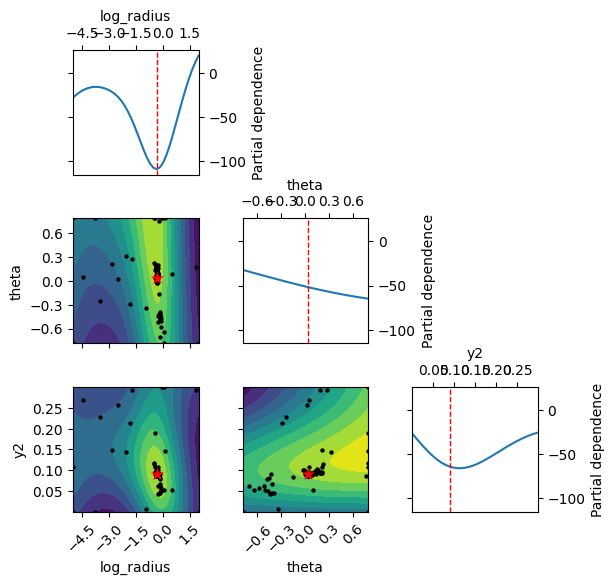

In [16]:
plot_objective(cr_gp1)

<Axes: >

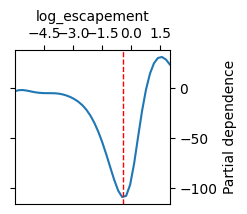

In [17]:
plot_objective(esc_gp1)

<Axes: >

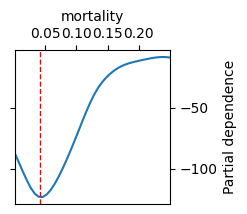

In [18]:
plot_objective(msy_gp1)

### 2

<Axes: >

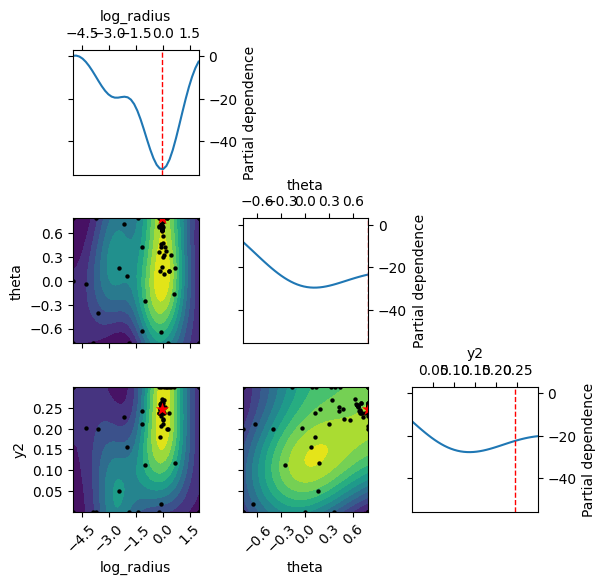

In [19]:
plot_objective(cr_gp2)

<Axes: >

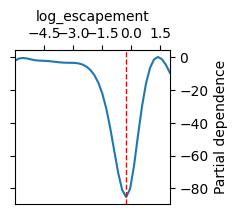

In [20]:
plot_objective(esc_gp2)

<Axes: >

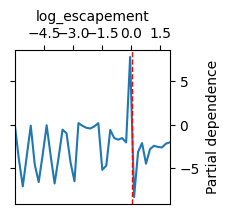

In [21]:
plot_objective(msy_gp2)

### 3

<Axes: >

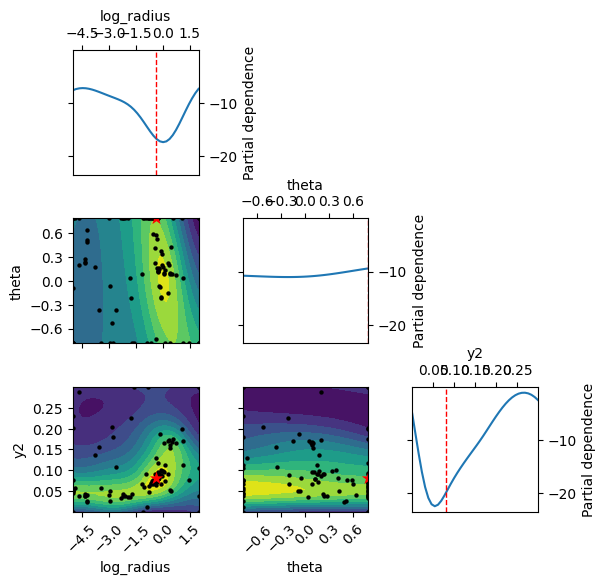

In [22]:
plot_objective(cr_gp3)

<Axes: >

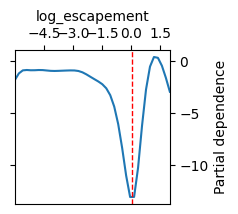

In [23]:
plot_objective(esc_gp3)

<Axes: >

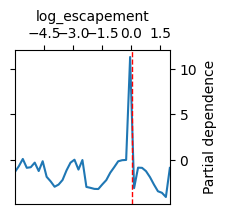

In [24]:
plot_objective(msy_gp3)

In [ ]:
cr_gp1